In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import sys
import pathlib
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import scipy.stats as st
from scipy.stats import linregress
from IPython.display import HTML, display
import csv
import pandas as pd
from scipy.stats import gaussian_kde


from IPython.display import set_matplotlib_formats

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
%load_ext autoreload
print("> Python libraries imported")

> Python libraries imported


In [2]:
path_to_uj="/home/esb/Projects/uJ/local/current/uJ_src_SingleChan/python/"
path_to_uj='/home/charly/Lab/Projects/uJ/local/current/uJ_src_SingleChan/python/'

sys.path.insert(0, path_to_uj)
%autoreload 

from AnalysisFunctions import *
from PlottingFunctions import *


> Analysis Functions loaded
Importing readroi
DataStructs...1loaded!
DataManagers...loaded!
PlottingFunctions... loaded p2!


In [7]:
pwd()

'/media/charly/Data/Lab/Projects/uJ/experiments_ms_pBGT/MGGT-AMP-Pulse'

In [8]:
## User-defined parameters
uj_data_path="/home/charly/Lab/Projects/uJ/uJ_data/"
#uj_data_path="/home/charly/Lab/Projects/uJ/uJ_data_online/"


expeLabel="MGGT-AMP-Pulse"

rootDir=uj_data_path+"MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/"

list_pos="xy01,xy04,xy05,xy06,xy07,xy09,xy12,xy13".split(",")

print(rootDir)


toFile=True
#Parameters 

frame2min=10


frame_experiment_start=10;
frame_experiment_end=34
frame_signal_start=16
frame_signal_end=20
frame_norm_start=10
frame_norm_end=15                  ### trick
frame_analysis_end=34



t_experiment_start=0
t_signal_start=(frame_signal_start-frame_experiment_start)*frame2min  
t_signal_end=(frame_signal_end-frame_experiment_start)*frame2min
t_experiment_end=(frame_experiment_end-frame_experiment_start)*frame2min

frames=range(int(frame_experiment_start),int(frame_experiment_end+1))
frames_list=[x for x in frames]
times=[(this_frame-frame_experiment_start)*frame2min for this_frame in frames]
times_hour=[(this_frame-frame_experiment_start)*frame2min/60 for this_frame in frames]
print("\nMinutes:  %s"%times)
print("\nHours:  [%s,%s]"%(times_hour[0],times_hour[-1]))


print("\nFrames:  %s\t %s->%s hours"%(frames,times_hour[0],times_hour[-1]))
print("Frame list:  %s"%(frames_list))
print("Frame normalization range:%s - %s\n"%(frame_norm_start,frame_norm_end))
print("Frame analysis range:%s - %s\n"%(frame_experiment_start,frame_analysis_end))
print("Frame signal range:%s - %s\n"%(frame_signal_start,frame_signal_end))

print("t_experiment_start=%s\t(%sh)"%(t_experiment_start, t_experiment_start/60))
print("t_signal_start=%s\t(%sh)"%(t_signal_start,t_signal_start/60))
print("t_signal_end=%s\t(%sh)"%(t_signal_end, t_signal_end/60))
print("t_experiment_end=%s\t(%sh)"%(t_experiment_end, t_experiment_end/60))


#Prepare file system
dataPath="%sdata/MERGE/"%rootDir

figurePath="%sfigures/"%rootDir
if not os.path.exists(figurePath) and toFile:
    os.mkdir(figurePath)

normDataPath="%sdata/normData/"%rootDir
if not os.path.exists(normDataPath) and toFile:
    os.mkdir(normDataPath)


    
    
print("\n> Parameters loaded")

/home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/

Minutes:  [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240]

Hours:  [0.0,4.0]

Frames:  range(10, 35)	 0.0->4.0 hours
Frame list:  [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
Frame normalization range:10 - 15

Frame analysis range:10 - 34

Frame signal range:16 - 20

t_experiment_start=0	(0.0h)
t_signal_start=60	(1.0h)
t_signal_end=100	(1.6666666666666667h)
t_experiment_end=240	(4.0h)

> Parameters loaded


## Read data files

In [9]:

data_pos=[]
data_frame=[]
data_GFP=[]
data_DsRed=[]

pop_df_list=[]
loaded_frames=0;
for root, dirs, files in os.walk(dataPath):
    dirs.sort()
    files.sort()
    #print("*",dirs)
    path = root.split(os.sep)
    if(not path[-1] in list_pos):
        continue
    #print(path)
    trap_df_list=[]
    for file in files:
        #trap_pos_df=pd.DataFrame()
        extension=""
        if len(os.path.splitext(file))>0:
            extension=pathlib.Path(file).suffix
        filePath = os.path.join(root,file)
        #print("1",file)
        if extension != ".txt":
            continue
        if extension == ".txt":
            #print("2",file)
            fileframe=file.split('_')[-1].split('.')[0]
            
            if(int(fileframe)>frame_experiment_end):
                continue
            print("%s\t%s"%(path,fileframe), end='\r')
            #print("Loading data from: " + file)
            
            data=fromFileData(filePath)
            this_pos=[]
            this_frame=[]
            this_GFP=[]
            this_DsRed=[]
            this_imgGFP=[]
            this_imgDsRed=[]
            this_phi=[]
            this_rho=[]
            this_id=[]
            this_label=[]
            for roi in data:
                this_id.append(int(roi[1]))
                this_imgGFP.append(str(roi[2]))
                this_imgDsRed.append(str(roi[3]))
                this_pos.append(str(roi[4]))
                this_frame.append(int(roi[5]))
                this_label.append(str(roi[6]))
                gfp=float(roi[7])
                dsred=float(roi[8])
                this_GFP.append(gfp)
                this_DsRed.append(dsred)
                
                
            data_pos.extend(this_pos)
            data_frame.extend(this_frame)
            data_GFP.extend(this_GFP)
            data_DsRed.extend(this_DsRed)
            
            loaded_frames+=1
        
        
        trap_pos_df=pd.DataFrame({"pos":this_pos,"frame":this_frame,"id":this_id,"imgGFP":this_imgGFP,"imgDsRed":this_imgDsRed,"label":this_label,"GFP":this_GFP,"DsRed":this_DsRed})        
        trap_df_list.append(trap_pos_df)
    print()
    if trap_df_list:
        trap_df=pd.concat(trap_df_list)
        pop_df_list.append(trap_df)

pop_df=pd.concat(pop_df_list)
            
data_frame=np.asarray(data_frame)
data_GFP=np.asarray(data_GFP)
data_DsRed=np.asarray(data_DsRed)
data_pos=np.asarray(data_pos)

print("> Data loaded (%s cells from %s images)"%(len(data_GFP), loaded_frames))

['', 'home', 'charly', 'Lab', 'Projects', 'uJ', 'uJ_data', 'MGGT-AMP-Pulse', '20190828_Bruno_MGGT_quimiostato', 'data', 'MERGE', 'xy01']	034
['', 'home', 'charly', 'Lab', 'Projects', 'uJ', 'uJ_data', 'MGGT-AMP-Pulse', '20190828_Bruno_MGGT_quimiostato', 'data', 'MERGE', 'xy04']	034
['', 'home', 'charly', 'Lab', 'Projects', 'uJ', 'uJ_data', 'MGGT-AMP-Pulse', '20190828_Bruno_MGGT_quimiostato', 'data', 'MERGE', 'xy05']	034
['', 'home', 'charly', 'Lab', 'Projects', 'uJ', 'uJ_data', 'MGGT-AMP-Pulse', '20190828_Bruno_MGGT_quimiostato', 'data', 'MERGE', 'xy06']	034
['', 'home', 'charly', 'Lab', 'Projects', 'uJ', 'uJ_data', 'MGGT-AMP-Pulse', '20190828_Bruno_MGGT_quimiostato', 'data', 'MERGE', 'xy07']	034
['', 'home', 'charly', 'Lab', 'Projects', 'uJ', 'uJ_data', 'MGGT-AMP-Pulse', '20190828_Bruno_MGGT_quimiostato', 'data', 'MERGE', 'xy09']	034
['', 'home', 'charly', 'Lab', 'Projects', 'uJ', 'uJ_data', 'MGGT-AMP-Pulse', '20190828_Bruno_MGGT_quimiostato', 'data', 'MERGE', 'xy12']	034
['', 'home', 

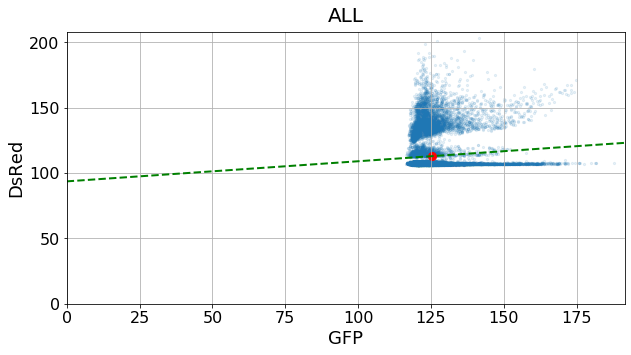

In [10]:
plt=plot_Raw_flourescence(pop_df["GFP"],pop_df["DsRed"],"ALL","GFP","DsRed",0,0)
plt.show()
plt.close()

# for trap in list_pos:
#     trap_df=pop_df[pop_df['pos']==trap].copy()
    
#     plt=plot_Raw_flourescence(trap_df["GFP"],trap_df["DsRed"],trap,"GFP","DsRed",0,0)
#     plt.show()
#     plt.close()


## Normalizing Fluorescence
### Calculate deviation over mean

In [11]:
trapDF_list=[]
pop_df_=pop_df.copy()


pop_df_norm=pop_df[(pop_df['frame']>=frame_norm_start)&(pop_df['frame']<=frame_norm_end)].copy()
meanGFPn=pop_df_norm['GFP'].mean()
meanDsRedn=pop_df_norm['DsRed'].mean()
maxGFPn=pop_df_norm['GFP'].max()
maxDsRedn=pop_df_norm['DsRed'].max()

print("Reference values:")
print("Mean GFP: ",meanGFPn)
print("Mean DsRed: ",meanDsRedn)
print("Max GFP: ",maxGFPn)
print("Max DsRed: ",maxDsRedn)


print("Normalizing flourescence...")
for trap in list_pos:
    trap_df=pop_df[pop_df['pos']==trap].copy()
    
    print(trap, end=' ')

    gfps=trap_df["GFP"]
    rfps=trap_df["DsRed"]
    pos=trap_df['pos']
    ids=trap_df['id']
    this_frames=trap_df['frame']
    relInt=[]
    absInt=[]
    relIntR=[]
    absIntR=[]
    for this_gfp,this_rfp in zip(gfps,rfps):
        
        riG=this_gfp-meanGFPn
        relInt.append(riG)
        ai=this_gfp/meanGFPn
        absInt.append(ai)
        
        riR=this_rfp-meanDsRedn
        relIntR.append(riR)
        ai=this_rfp/meanDsRedn
        absIntR.append(ai)
        

    trapDF=pd.DataFrame({"pos":pos,"frame":this_frames,"id":ids,"Norm_GFP":relInt,"Norm_GFP1":absInt,"Norm_Red":relIntR,"Norm_Red1":absIntR})
    trapDF_list.append(trapDF)
trapDF=pd.concat(trapDF_list)
pop_df_plus=pd.merge(pop_df_,trapDF,on=['pos','frame','id'])
trapDF=[]
pop_df_=[]

Reference values:
Mean GFP:  122.08274150626536
Mean DsRed:  107.74012646944853
Max GFP:  144.628
Max DsRed:  110.058
Normalizing flourescence...
xy01 xy04 xy05 xy06 xy07 xy09 xy12 xy13 

In [12]:
pop_df_plus.head()

,pos,frame,id,imgGFP,imgDsRed,label,GFP,DsRed,Norm_GFP,Norm_GFP1,Norm_Red,Norm_Red1
0,xy01,10,0,MGGT-AMP-Pulse_xy01_GFP_010.tif,MGGT-AMP-Pulse_xy01_DsRed_010.tif,roi_f10_n0_x273_y297,119.881,108.319,-2.201742,0.981965,0.578874,1.005373
1,xy01,10,1,MGGT-AMP-Pulse_xy01_GFP_010.tif,MGGT-AMP-Pulse_xy01_DsRed_010.tif,roi_f10_n1_x289_y277,119.350,108.350,-2.732742,0.977616,0.609874,1.005661
2,xy01,10,2,MGGT-AMP-Pulse_xy01_GFP_010.tif,MGGT-AMP-Pulse_xy01_DsRed_010.tif,roi_f10_n2_x308_y243,119.621,108.584,-2.461742,0.979835,0.843874,1.007832
3,xy01,10,3,MGGT-AMP-Pulse_xy01_GFP_010.tif,MGGT-AMP-Pulse_xy01_DsRed_010.tif,roi_f10_n3_x126_y248,119.283,108.414,-2.799742,0.977067,0.673874,1.006255
4,xy01,10,4,MGGT-AMP-Pulse_xy01_GFP_010.tif,MGGT-AMP-Pulse_xy01_DsRed_010.tif,roi_f10_n4_x144_y243,118.616,108.394,-3.466742,0.971603,0.653874,1.006069


In [13]:
pop_df_plus.tail()

,pos,frame,id,imgGFP,imgDsRed,label,GFP,DsRed,Norm_GFP,Norm_GFP1,Norm_Red,Norm_Red1
28447,xy13,34,36,MGGT-AMP-Pulse_xy13_GFP_034.tif,MGGT-AMP-Pulse_xy13_DsRed_034.tif,roi_f34_n36_x233_y134,120.947,106.526,-1.135742,0.990697,-1.214126,0.988731
28448,xy13,34,37,MGGT-AMP-Pulse_xy13_GFP_034.tif,MGGT-AMP-Pulse_xy13_DsRed_034.tif,roi_f34_n37_x178_y128,121.354,106.582,-0.728742,0.994031,-1.158126,0.989251
28449,xy13,34,38,MGGT-AMP-Pulse_xy13_GFP_034.tif,MGGT-AMP-Pulse_xy13_DsRed_034.tif,roi_f34_n38_x189_y123,120.605,106.434,-1.477742,0.987896,-1.306126,0.987877
28450,xy13,34,39,MGGT-AMP-Pulse_xy13_GFP_034.tif,MGGT-AMP-Pulse_xy13_DsRed_034.tif,roi_f34_n39_x235_y115,120.006,106.865,-2.076742,0.982989,-0.875126,0.991877
28451,xy13,34,40,MGGT-AMP-Pulse_xy13_GFP_034.tif,MGGT-AMP-Pulse_xy13_DsRed_034.tif,roi_f34_n40_x173_y101,121.864,107.092,-0.218742,0.998208,-0.648126,0.993984


In [14]:
html_table=[]

for frame in frames:
    #print(frame)
    this_time=frame*frame2min
    this_GFP=pop_df_plus[pop_df_plus['frame']==frame]['GFP']
    this_DsRed=pop_df_plus[pop_df_plus['frame']==frame]['DsRed']
    this_rG=pop_df_plus[pop_df_plus['frame']==frame]['Norm_GFP'].mean()
    this_rR=pop_df_plus[pop_df_plus['frame']==frame]['Norm_Red'].mean()
    this_freq=pop_df_plus[pop_df_plus['frame']==frame]['Norm_GFP1'].mean()
    this_cells=len(this_GFP)
    html_row=("%s,%s,%.1f,%.3f,%.1f,%.3f,%.4f,%s"
              %(this_time,frame,np.mean(this_GFP),this_rG,np.mean(this_DsRed),this_rR,this_freq,this_cells)).split(",")
    html_table.append(html_row)

In [15]:

display(HTML(
    '<table><tr><td width="5%">time (min)</td><td width="5%">Frame</td><td width="5%">Mean(GFP) </td><td width="6%">Mean(GFP)/Baseline(GFP)</td><td width="10%">Mean(DsRed) </td><td width="5%"> Mean(DsRed)/Baseline(DsRed) </td><td width="10%">Relative Intensity</td><td>Number of Cells</td></tr><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
        '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in html_table)
    )
))

HTML(value='<table><tr><td width="5%">time (min)</td><td width="5%">Frame</td><td width="5%">Mean(GFP) </td><t…

## Plot raw mean fluorescence

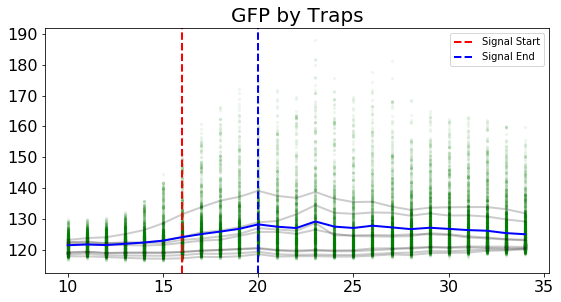

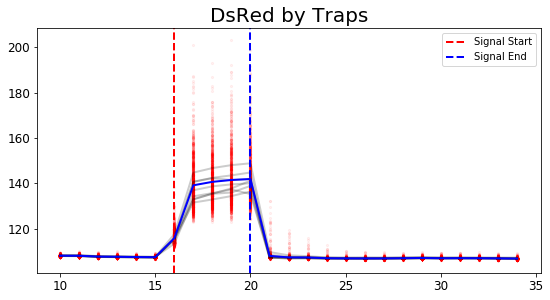

In [16]:
fig, ax = plt.subplots(ncols=1, figsize=(10,4.5))
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})
pop_mean_dev=[]

ylim_up=1
ylim_down=-1

for frame in frames_list:
    this_frame_df=pop_df_plus[pop_df_plus['frame']==frame]
    this_frame_dev=this_frame_df['GFP'].mean()
    pop_mean_dev.append(this_frame_dev)
    y=list(this_frame_df['GFP'])
    x=[frame]*len(y)
    #print(len(x),len(y))
    ax.scatter(x,y,s=5,alpha=.05,c='g')
    #for this_x in this_frame_df['GFP']:
     #   ax.scatter(frame,this_x,alpha=.1,c='g')
    
ax.plot(frames_list,pop_mean_dev,c='b',zorder=3)


#c=0
for trap in list_pos:
    trap_df=pop_df_plus[pop_df_plus['pos']==trap].copy()
    
    
    trap_frame_dev=[]
    for frame in frames_list:
        this_trap_frame_df=trap_df[trap_df['frame']==frame]
        this_trap_frame_dev=this_trap_frame_df['GFP'].mean()
        trap_frame_dev.append(this_trap_frame_dev)
    ax.plot(frames_list,trap_frame_dev,c='k',alpha=.2)
    #print(trap,frame,trap_frame_dev[-1])
#ax.set_ylim(top=.5,bottom=-.5)
ax.axvline(x=frame_signal_start,color='r',linestyle='dashed',label='Signal Start')
ax.axvline(x=frame_signal_end,color='b',linestyle='dashed',label='Signal End')
#ax.axvline(frame_signal_start,ylim_down,ylim_down,colors='k',linestyles='dashed', label='sds')
ax.set_title('GFP by Traps')
ax.legend(fontsize='small')
plt.show()
plt.close()


fig, ax = plt.subplots(ncols=1, figsize=(10,4.5))
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})
pop_mean_dev=[]

ylim_up=1
ylim_down=-1

for frame in frames_list:
    this_frame_df=pop_df_plus[pop_df_plus['frame']==frame]
    this_frame_dev=this_frame_df['DsRed'].mean()
    pop_mean_dev.append(this_frame_dev)
    y=list(this_frame_df['DsRed'])
    x=[frame]*len(y)
    #print(len(x),len(y))
    ax.scatter(x,y,s=5,alpha=.05,c='r')
    #for this_x in this_frame_df['DsRed']:
     #   ax.scatter(frame,this_x,alpha=.1,c='r')
    
    
ax.plot(frames_list,pop_mean_dev,c='b',zorder=3)


#c=0
for trap in list_pos:
    trap_df=pop_df_plus[pop_df_plus['pos']==trap].copy()
    
    
    trap_frame_dev=[]
    for frame in frames_list:
        this_trap_frame_df=trap_df[trap_df['frame']==frame]
        this_trap_frame_dev=this_trap_frame_df['DsRed'].mean()
        trap_frame_dev.append(this_trap_frame_dev)
    ax.plot(frames_list,trap_frame_dev,c='k',alpha=.2)
    #print(trap,frame,trap_frame_dev[-1])
#ax.set_ylim(top=.5,bottom=-.5)
ax.axvline(x=frame_signal_start,color='r',linestyle='dashed',label='Signal Start')
ax.axvline(x=frame_signal_end,color='b',linestyle='dashed',label='Signal End')
#ax.axvline(frame_signal_start,ylim_down,ylim_down,colors='k',linestyles='dashed', label='sds')
ax.set_title('DsRed by Traps')
ax.legend(fontsize='small')
plt.show()
plt.close()

## Plot raw mean fluorescence

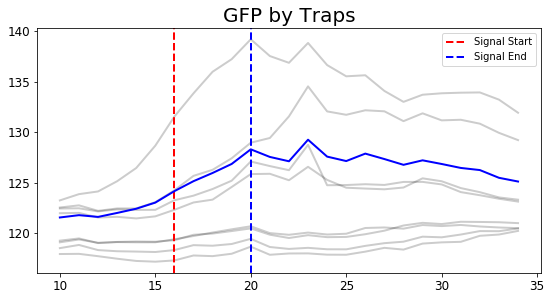

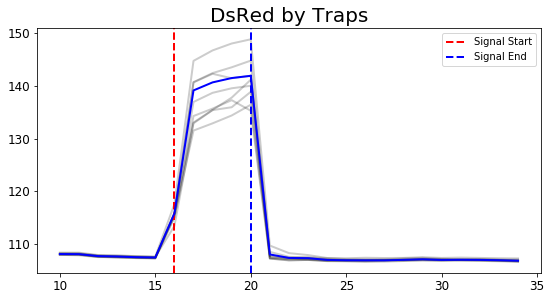

In [17]:
fig, ax = plt.subplots(ncols=1, figsize=(10,4.5))
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})
pop_mean_dev=[]

ylim_up=1
ylim_down=-1

for frame in frames_list:
    this_frame_df=pop_df_plus[pop_df_plus['frame']==frame]
    this_frame_dev=this_frame_df['GFP'].mean()
    pop_mean_dev.append(this_frame_dev)

    
ax.plot(frames_list,pop_mean_dev,c='b',zorder=3)


#c=0
for trap in list_pos:
    trap_df=pop_df_plus[pop_df_plus['pos']==trap].copy()
    
    
    trap_frame_dev=[]
    for frame in frames_list:
        this_trap_frame_df=trap_df[trap_df['frame']==frame]
        this_trap_frame_dev=this_trap_frame_df['GFP'].mean()
        trap_frame_dev.append(this_trap_frame_dev)
    ax.plot(frames_list,trap_frame_dev,c='k',alpha=.2)
    #print(trap,frame,trap_frame_dev[-1])
#ax.set_ylim(top=.5,bottom=-.5)
ax.axvline(x=frame_signal_start,color='r',linestyle='dashed',label='Signal Start')
ax.axvline(x=frame_signal_end,color='b',linestyle='dashed',label='Signal End')
#ax.axvline(frame_signal_start,ylim_down,ylim_down,colors='k',linestyles='dashed', label='sds')
ax.set_title('GFP by Traps')
ax.legend(fontsize='small')
plt.show()
plt.close()


fig, ax = plt.subplots(ncols=1, figsize=(10,4.5))
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})
pop_mean_dev=[]

ylim_up=1
ylim_down=-1

for frame in frames_list:
    this_frame_df=pop_df_plus[pop_df_plus['frame']==frame]
    this_frame_dev=this_frame_df['DsRed'].mean()
    pop_mean_dev.append(this_frame_dev)

    
ax.plot(frames_list,pop_mean_dev,c='b',zorder=3)


#c=0
for trap in list_pos:
    trap_df=pop_df_plus[pop_df_plus['pos']==trap].copy()
    
    
    trap_frame_dev=[]
    for frame in frames_list:
        this_trap_frame_df=trap_df[trap_df['frame']==frame]
        this_trap_frame_dev=this_trap_frame_df['DsRed'].mean()
        trap_frame_dev.append(this_trap_frame_dev)
    ax.plot(frames_list,trap_frame_dev,c='k',alpha=.2)
    #print(trap,frame,trap_frame_dev[-1])
#ax.set_ylim(top=.5,bottom=-.5)
ax.axvline(x=frame_signal_start,color='r',linestyle='dashed',label='Signal Start')
ax.axvline(x=frame_signal_end,color='b',linestyle='dashed',label='Signal End')
#ax.axvline(frame_signal_start,ylim_down,ylim_down,colors='k',linestyles='dashed', label='sds')
ax.set_title('DsRed by Traps')
ax.legend(fontsize='small')
plt.show()
plt.close()

## Plot deviation over mean

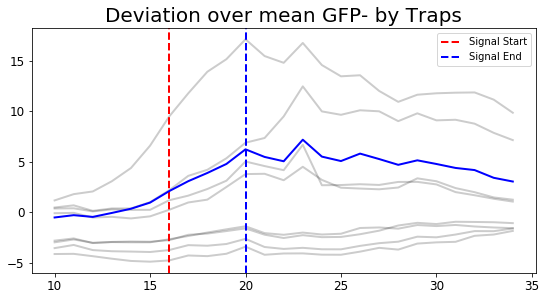

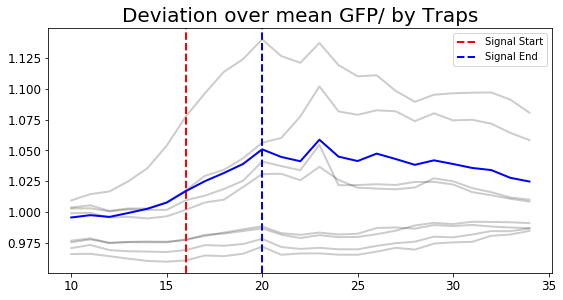

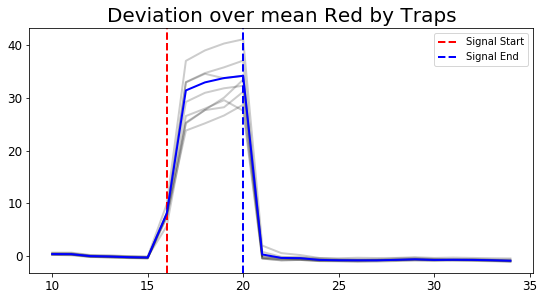

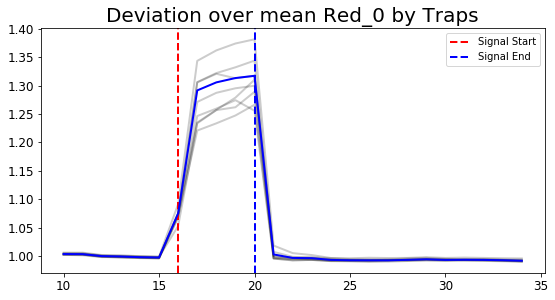

In [18]:
fig, ax = plt.subplots(ncols=1, figsize=(10,4.5))
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})
pop_mean_dev=[]

ylim_up=1
ylim_down=-1

for frame in frames_list:
    this_frame_df=pop_df_plus[pop_df_plus['frame']==frame]
    this_frame_dev=this_frame_df['Norm_GFP'].mean()
    pop_mean_dev.append(this_frame_dev)

    
ax.plot(frames_list,pop_mean_dev,c='b',zorder=3)


#c=0
for trap in list_pos:
    trap_df=pop_df_plus[pop_df_plus['pos']==trap].copy()
    
    
    trap_frame_dev=[]
    for frame in frames_list:
        this_trap_frame_df=trap_df[trap_df['frame']==frame]
        this_trap_frame_dev=this_trap_frame_df['Norm_GFP'].mean()
        trap_frame_dev.append(this_trap_frame_dev)
    ax.plot(frames_list,trap_frame_dev,c='k',alpha=.2)
    #print(trap,frame,trap_frame_dev[-1])
#ax.set_ylim(top=.5,bottom=-.5)
ax.axvline(x=frame_signal_start,color='r',linestyle='dashed',label='Signal Start')
ax.axvline(x=frame_signal_end,color='b',linestyle='dashed',label='Signal End')
#ax.axvline(frame_signal_start,ylim_down,ylim_down,colors='k',linestyles='dashed', label='sds')
ax.set_title('Deviation over mean GFP- by Traps')
ax.legend(fontsize='small')
plt.show()
plt.close()



fig, ax = plt.subplots(ncols=1, figsize=(10,4.5))
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})
pop_mean_dev=[]

ylim_up=1
ylim_down=-1

for frame in frames_list:
    this_frame_df=pop_df_plus[pop_df_plus['frame']==frame]
    this_frame_dev=this_frame_df['Norm_GFP1'].mean()
    pop_mean_dev.append(this_frame_dev)

    
ax.plot(frames_list,pop_mean_dev,c='b',zorder=3)


#c=0
for trap in list_pos:
    trap_df=pop_df_plus[pop_df_plus['pos']==trap].copy()
    
    
    trap_frame_dev=[]
    for frame in frames_list:
        this_trap_frame_df=trap_df[trap_df['frame']==frame]
        this_trap_frame_dev=this_trap_frame_df['Norm_GFP1'].mean()
        trap_frame_dev.append(this_trap_frame_dev)
    ax.plot(frames_list,trap_frame_dev,c='k',alpha=.2)
    #print(trap,frame,trap_frame_dev[-1])
#ax.set_ylim(top=.5,bottom=-.5)
ax.axvline(x=frame_signal_start,color='r',linestyle='dashed',label='Signal Start')
ax.axvline(x=frame_signal_end,color='b',linestyle='dashed',label='Signal End')
#ax.axvline(frame_signal_start,ylim_down,ylim_down,colors='k',linestyles='dashed', label='sds')
ax.set_title('Deviation over mean GFP/ by Traps')
ax.legend(fontsize='small')
plt.show()
plt.close()

fig, ax = plt.subplots(ncols=1, figsize=(10,4.5))
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})
pop_mean_dev=[]

ylim_up=1
ylim_down=-1

for frame in frames_list:
    this_frame_df=pop_df_plus[pop_df_plus['frame']==frame]
    this_frame_dev=this_frame_df['Norm_Red'].mean()
    pop_mean_dev.append(this_frame_dev)

    
ax.plot(frames_list,pop_mean_dev,c='b',zorder=3)


#c=0
for trap in list_pos:
    trap_df=pop_df_plus[pop_df_plus['pos']==trap].copy()
    
    
    trap_frame_dev=[]
    for frame in frames_list:
        this_trap_frame_df=trap_df[trap_df['frame']==frame]
        this_trap_frame_dev=this_trap_frame_df['Norm_Red'].mean()
        trap_frame_dev.append(this_trap_frame_dev)
    ax.plot(frames_list,trap_frame_dev,c='k',alpha=.2)
    #print(trap,frame,trap_frame_dev[-1])
#ax.set_ylim(top=.5,bottom=-.5)
ax.axvline(x=frame_signal_start,color='r',linestyle='dashed',label='Signal Start')
ax.axvline(x=frame_signal_end,color='b',linestyle='dashed',label='Signal End')
#ax.axvline(frame_signal_start,ylim_down,ylim_down,colors='k',linestyles='dashed', label='sds')
ax.set_title('Deviation over mean Red by Traps')
ax.legend(fontsize='small')
plt.show()
plt.close()



fig, ax = plt.subplots(ncols=1, figsize=(10,4.5))
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})
pop_mean_dev=[]

ylim_up=1
ylim_down=-1

for frame in frames_list:
    this_frame_df=pop_df_plus[pop_df_plus['frame']==frame]
    this_frame_dev=this_frame_df['Norm_Red1'].mean()
    pop_mean_dev.append(this_frame_dev)

    
ax.plot(frames_list,pop_mean_dev,c='b',zorder=3)


#c=0
for trap in list_pos:
    trap_df=pop_df_plus[pop_df_plus['pos']==trap].copy()
    
    
    trap_frame_dev=[]
    for frame in frames_list:
        this_trap_frame_df=trap_df[trap_df['frame']==frame]
        this_trap_frame_dev=this_trap_frame_df['Norm_Red1'].mean()
        trap_frame_dev.append(this_trap_frame_dev)
    ax.plot(frames_list,trap_frame_dev,c='k',alpha=.2)
    #print(trap,frame,trap_frame_dev[-1])
#ax.set_ylim(top=.5,bottom=-.5)
ax.axvline(x=frame_signal_start,color='r',linestyle='dashed',label='Signal Start')
ax.axvline(x=frame_signal_end,color='b',linestyle='dashed',label='Signal End')
#ax.axvline(frame_signal_start,ylim_down,ylim_down,colors='k',linestyles='dashed', label='sds')
ax.set_title('Deviation over mean Red_0 by Traps')
ax.legend(fontsize='small')
plt.show()
plt.close()




## Save Data

In [19]:
export_list=[normDataPath]
relInt_list=["Norm_GFP1"]
#relInt_list=["relInt","dev_mean","dev_mean_N"] ?
absInt_list=["Norm_Red1"]


for pos in list_pos:
    df_pos=pop_df_plus[pop_df_plus['pos']==pos]
    
    for frame in frames_list:
        df_pos_frame=df_pos[df_pos["frame"]==frame]
        #print(df_pos_frame.head())
        ids=df_pos_frame['id']
        imgsGFP=df_pos_frame['imgGFP']
        imgsDsRed=df_pos_frame['imgDsRed']
        this_pos=df_pos_frame['pos']
        this_frame=df_pos_frame['frame']
        this_label=df_pos_frame['label']
        this_GFP=df_pos_frame['GFP']
        this_DsRed=df_pos_frame['DsRed']
        
        framestr=str(frame).zfill(3)
        fileNamep="%s_%s_%s.txt"%(expeLabel,pos,framestr)
        
        for i in range(len(export_list)):
            exportPath=export_list[i]
            relInt_type=relInt_list[i]
            absInt_type=absInt_list[i]
            
            this_relInt=df_pos_frame[relInt_type]
            this_absInt=df_pos_frame[absInt_type]
            
            rows=zip(ids,imgsGFP,imgsDsRed,this_pos,this_frame,this_label,this_GFP,this_DsRed,this_relInt,this_absInt)
                 
            outPath=os.path.join(exportPath,pos)
            if not os.path.exists(outPath):
                os.mkdir(outPath)
            
            fileName=os.path.join(outPath,fileNamep)
            toFileData(fileName, rows)
            print("%s %s"%(pos,fileName),end='\r')
    print()

xy01 /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data/normData/xy01/MGGT-AMP-Pulse_xy01_034.txt
xy04 /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data/normData/xy04/MGGT-AMP-Pulse_xy04_034.txt
xy05 /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data/normData/xy05/MGGT-AMP-Pulse_xy05_034.txt
xy06 /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data/normData/xy06/MGGT-AMP-Pulse_xy06_034.txt
xy07 /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data/normData/xy07/MGGT-AMP-Pulse_xy07_034.txt
xy09 /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data/normData/xy09/MGGT-AMP-Pulse_xy09_034.txt
xy12 /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data/normData/xy12/MGGT-AMP-Pulse_xy12_034.txt
xy13 /home/charly/Lab/Projects/uJ/uJ_data/MGGT-A

## Deviation over the mean


Aggregate cells from all traps.  
Normalize time-series with respect to population-level mean.


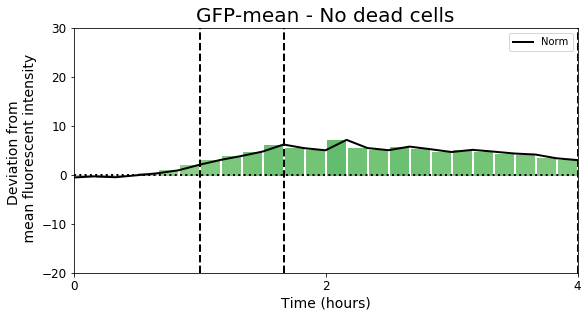

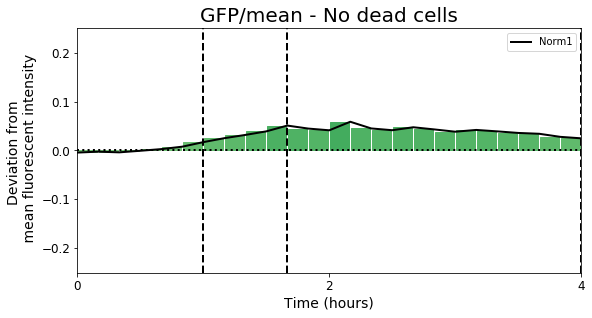


Saved as /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/figures/MGGT-AMP-Pulse_time_v_meanDev.tif


In [20]:
DsRed_threshold=300

freqs_rel2=[]
freqs_abs2=[]
frames=range(int(frame_experiment_start),int(frame_experiment_end+1))

for frame in frames:
    tdf=pop_df_plus[pop_df_plus['frame']==frame].copy()
    tdf=tdf[tdf['DsRed']<DsRed_threshold].copy()
    frame_gfps=tdf['Norm_GFP'].mean()
    freqs_rel2.append(frame_gfps)
    frame_gfps=tdf['Norm_GFP1'].mean()
    freqs_abs2.append(frame_gfps)


#################################################################
freqs=freqs_rel2.copy()
interv=1
Ncolors=100
ymin=-20
ymax=30




#Plot figure
fig, ax = plt.subplots(ncols=1, figsize=(10, 4.5))
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})

dx=(frames[1]-frames[0])*frame2min
xdev=[(this_x-frame2min*interv/2) for this_x in times[:]]
ydev=[this_y for this_y in freqs[:]]

cmap = cm.get_cmap("Greens", Ncolors+1) #generate a jet map with 10 values 
cmap_vals = cmap(np.arange(Ncolors+1))


dy=(ymax+np.abs(ymin))/Ncolors
ls=np.arange(ymin,ymax+dy,dy)
colors=[]
for thisy in ydev:
    thisColor=cmap_vals[find_nearest(ls,thisy),:]
    colors.append(thisColor)

ax.bar(xdev,ydev,0.9*interv*frame2min, color = colors, edgecolor =  colors)
ax.plot(times,ydev,color='black', linewidth=2,label="Norm")
#ax.plot(times,ydev_phi,color='blue', linewidth=1,label="phi")
#ax.plot(times,ydev_phi_N,color='green', linewidth=1,label="phiN")

ax.plot([0,t_experiment_end],[0,0], 'k:')

ix=range(t_experiment_start*frame2min,t_experiment_end*frame2min,120)
lx= [int(index/60) for index in ix]
ax.set_xticks(ix)
ax.set_xticklabels(lx)

#Annotates signal
ax.axvline(t_signal_start, color='k', linestyle='--')
ax.axvline(t_signal_end, color='k', linestyle='--')
ax.axvline(t_experiment_end, color='k', linestyle='--')
ax.axis([t_experiment_start,t_experiment_end,ymin,ymax])

#ax.set_axis_bgcolor('white')
ax.set_xlabel('Time (hours)',fontsize=14)
ax.set_ylabel('Deviation from \n mean fluorescent intensity',fontsize=14)
ax.set_title(label="GFP-mean - No dead cells")
ax.legend(fontsize='small')
#figName='%s%s_time_v_intensity_rel.tif'%(figurePath, expeLabel)
#plt.savefig(figName)    
plt.show()
#print("\nSaved as %s"%figName)



##########################################################
freqs=freqs_abs2.copy()
ymin=-.25
ymax=.25




#Plot figure
fig, ax = plt.subplots(ncols=1, figsize=(10, 4.5))
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})

dx=(frames[1]-frames[0])*frame2min
xdev=[(this_x-frame2min*interv/2) for this_x in times[:]]
ydev=[this_y-1 for this_y in freqs[:]]

cmap = cm.get_cmap("Greens", Ncolors+1) #generate a jet map with 10 values 
cmap_vals = cmap(np.arange(Ncolors+1))


dy=(ymax+np.abs(ymin))/Ncolors
ls=np.arange(ymin,ymax+dy,dy)
colors=[]
for thisy in ydev:
    thisColor=cmap_vals[find_nearest(ls,thisy),:]
    colors.append(thisColor)

ax.bar(xdev,ydev,0.9*interv*frame2min, color = colors, edgecolor =  colors)
ax.plot(times,ydev,color='black', linewidth=2,label="Norm1")
#ax.plot(times,ydev_phi,color='blue', linewidth=1,label="phi")
#ax.plot(times,ydev_phi_N,color='green', linewidth=1,label="phiN")

ax.plot([0,t_experiment_end],[0,0], 'k:')

ix=range(t_experiment_start*frame2min,t_experiment_end*frame2min,120)
lx= [int(index/60) for index in ix]
ax.set_xticks(ix)
ax.set_xticklabels(lx)

#Annotates signal
ax.axvline(t_signal_start, color='k', linestyle='--')
ax.axvline(t_signal_end, color='k', linestyle='--')
ax.axvline(t_experiment_end, color='k', linestyle='--')
ax.axis([t_experiment_start,t_experiment_end,ymin,ymax])

#ax.set_axis_bgcolor('white')
ax.set_xlabel('Time (hours)',fontsize=14)
ax.set_ylabel('Deviation from \n mean fluorescent intensity',fontsize=14)
ax.set_title(label="GFP/mean - No dead cells")
ax.legend(fontsize='small')
figName='%s%s_time_v_meanDev.tif'%(figurePath, expeLabel)
plt.savefig(figName)    
plt.show()
print("\nSaved as %s"%figName)

freqs=[]



In [21]:
maxGFP=pop_df_plus[pop_df_plus['frame']<frame_analysis_end]['GFP'].max()
maxDsRed=pop_df_plus[pop_df_plus['frame']<frame_analysis_end]['DsRed'].max()
maxGFP,maxDsRed

(187.899, 203.094)

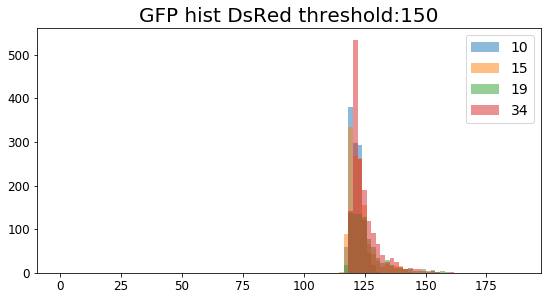

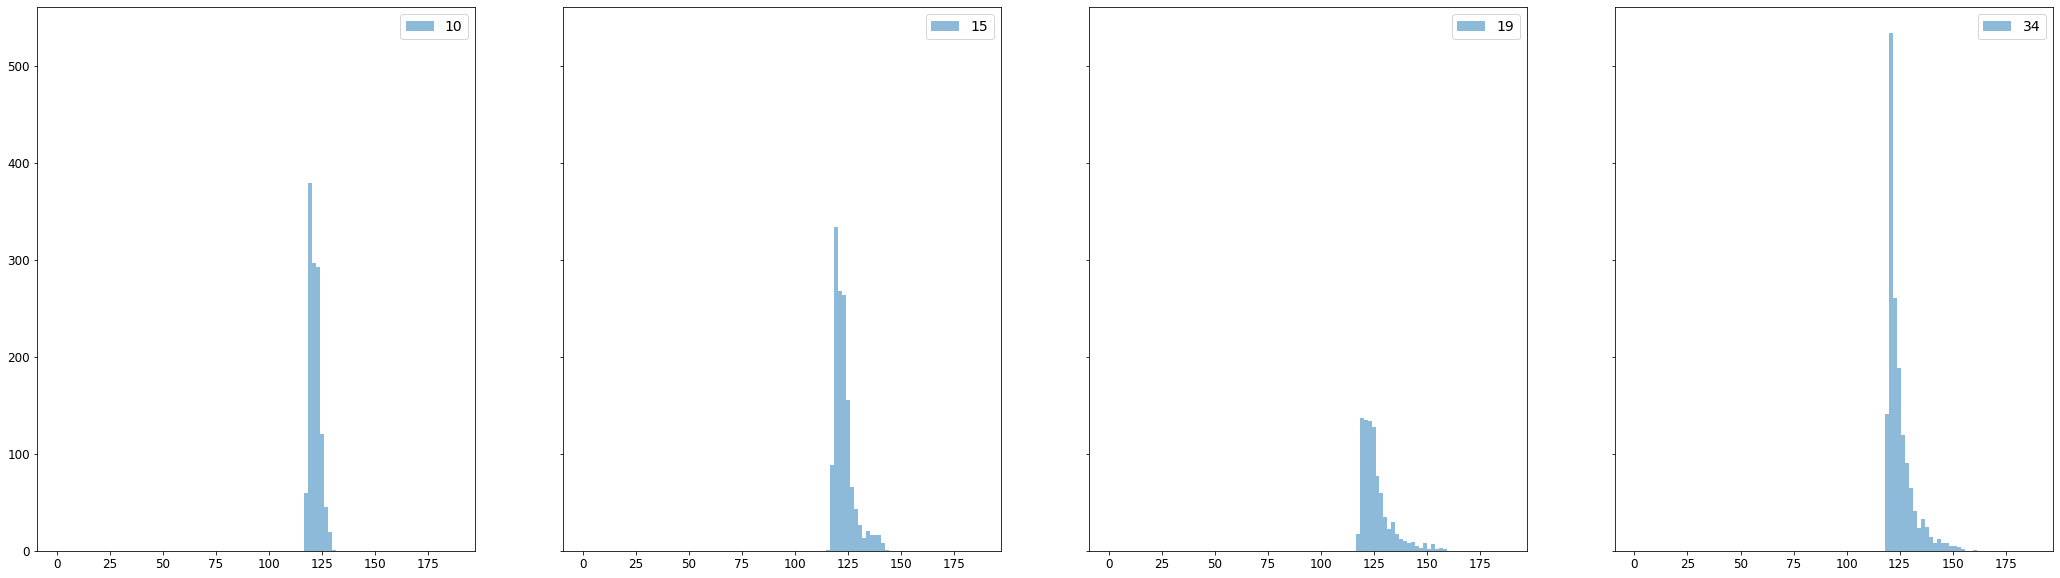

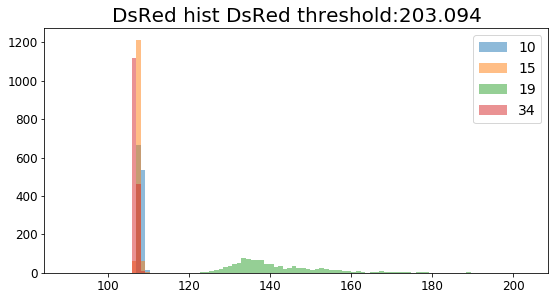

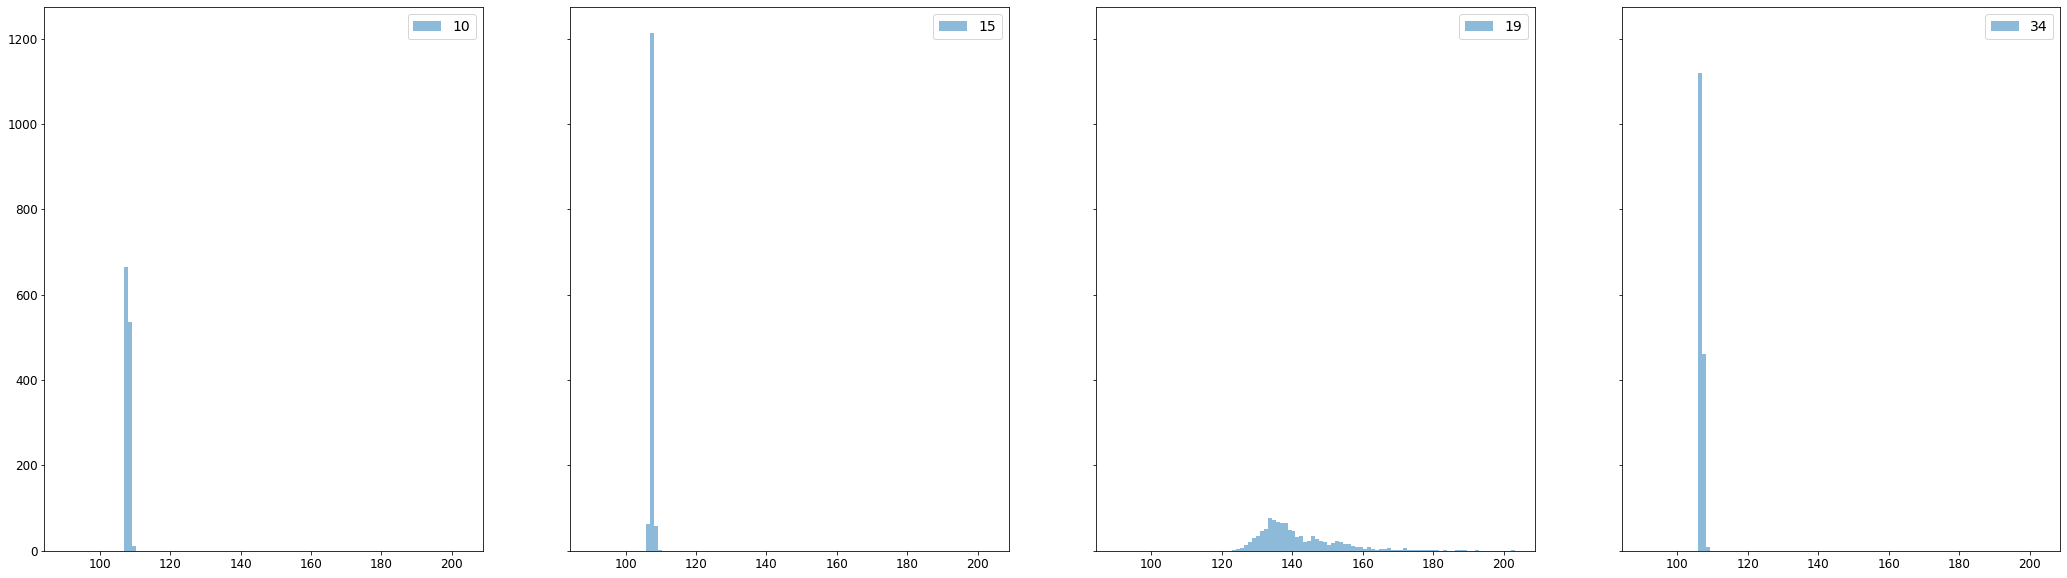

In [22]:
list_to_plot_frames=[frame_experiment_start,frame_norm_end,frame_signal_end-1,frame_analysis_end,frame_experiment_end]
list_to_plot_frames=[frame_experiment_start,frame_norm_end,frame_signal_end-1,frame_analysis_end]
DsRed_threshold=150



bin_num=100
bin_max =maxGFP
#bin_max =500
bin_min=0
bin_size = (bin_max-bin_min)/bin_num; 
N = int((bin_max-bin_min)/bin_size); Nplus1 = N + 1
bin_list = np.linspace(bin_min, bin_max, Nplus1)


fig, ax = plt.subplots(ncols=1, figsize=(10, 4.5))
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})
z=0
for this_frame in list_to_plot_frames:
    frame_df=pop_df_plus[pop_df_plus['frame']==this_frame].copy()
    frame_df=frame_df[frame_df['DsRed']<DsRed_threshold].copy()
    this_gfps=frame_df['GFP']
    ax.hist(this_gfps,bins=bin_list,label=str(this_frame),alpha=.5,zorder=z)
    z=z+1
plt.title("GFP hist DsRed threshold:%s"%(DsRed_threshold))
plt.legend()
plt.show()



fig, ax = plt.subplots(ncols=len(list_to_plot_frames), figsize=(40, 10),sharey=True)
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})
z=0
for this_frame in list_to_plot_frames:
    frame_df=pop_df_plus[pop_df_plus['frame']==this_frame].copy()
    frame_df=frame_df[frame_df['DsRed']<DsRed_threshold].copy()
    this_gfps=frame_df['GFP']
#     ax[z].text(1000,2300,"Cells:%d"%(len(this_gfps)))
#     ax[z].text(950,2100,"Mean GFP:%d"%(np.mean(this_gfps)))
#     ax[z].text(950,2000,"Std GFP:%d"%(np.std(this_gfps)))
#     ax[z].text(950,1900,"Cv GFP:%.3f"%(np.std(this_gfps)/np.mean(this_gfps)))
#     ax[z].text(950,1800,"max GFP:%d"%(np.max(this_gfps)))
#     ax[z].text(950,1700,"min GFP:%d"%(np.min(this_gfps)))
#     ax[z].text(800,1600,"DsRed threshold:%d"%(DsRed_threshold))
    ax[z].hist(this_gfps,bins=bin_list,label=str(this_frame),alpha=.5,zorder=z)
    ax[z].legend()
    z=z+1
#plt.legend()
#plt.yscale('log')
plt.show()

DsRed_threshold=maxDsRed
bin_num=100
bin_max =maxDsRed
#bin_max =150
bin_min=90
bin_size = (bin_max-bin_min)/bin_num; 
N = int((bin_max-bin_min)/bin_size); Nplus1 = N + 1
bin_list = np.linspace(bin_min, bin_max, Nplus1)


fig, ax = plt.subplots(ncols=1, figsize=(10, 4.5))
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})
for this_frame in list_to_plot_frames:
    frame_df=pop_df_plus[pop_df_plus['frame']==this_frame].copy()
    #frame_df=frame_df[frame_df['DsRed']<DsRed_threshold].copy()
    this_gfps=frame_df['DsRed']
    ax.hist(this_gfps,bins=bin_list,label=str(this_frame),alpha=.5)
    
plt.title("DsRed hist DsRed threshold:%s"%(DsRed_threshold))
plt.legend()
plt.show()


fig, ax = plt.subplots(ncols=len(list_to_plot_frames), figsize=(40, 10),sharey=True)
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})
z=0
for this_frame in list_to_plot_frames:
    frame_df=pop_df_plus[pop_df_plus['frame']==this_frame].copy()
    #frame_df=frame_df[frame_df['DsRed']<DsRed_threshold].copy()
    this_gfps=frame_df['DsRed']
#     ax[z].text(200,11000,"Cells:%d"%(len(this_gfps)))
#     ax[z].text(200,10000,"Mean RFP:%d"%(np.mean(this_gfps)))
#     ax[z].text(200,9500,"Std RFP:%d"%(np.std(this_gfps)))
#     ax[z].text(200,9000,"Cv RFP:%.3f"%(np.std(this_gfps)/np.mean(this_gfps)))
#     ax[z].text(200,8500,"max RFP:%d"%(np.max(this_gfps)))
#     ax[z].text(200,8000,"min RFP:%d"%(np.min(this_gfps)))
    ax[z].hist(this_gfps,bins=bin_list,label=str(this_frame),alpha=.5,zorder=z)
    ax[z].legend()
    z=z+1
#plt.legend()
#plt.yscale('log')
plt.show()


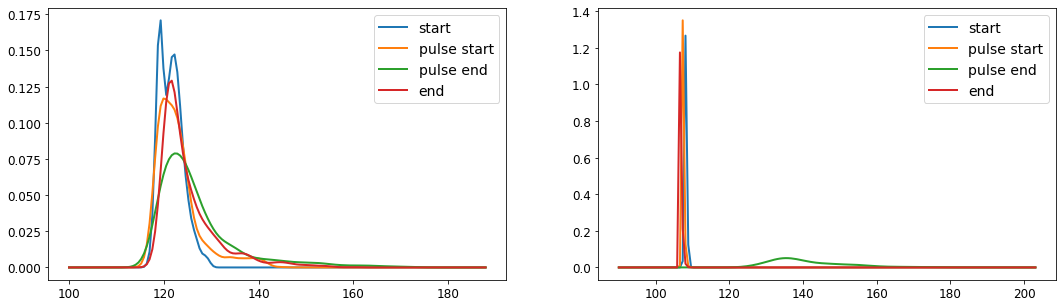

In [23]:
list_to_plot_frames=[frame_experiment_start,frame_norm_end,frame_signal_end-1,frame_analysis_end]
labels=["start","pulse start","pulse end","end"]
DsRed_threshold=250



bin_num=150
bin_max =maxGFP
bin_min=100
bin_size = (bin_max-bin_min)/bin_num; 
N = int((bin_max-bin_min)/bin_size); Nplus1 = N + 1
bin_listG = np.linspace(bin_min, bin_max, Nplus1)

bin_num=150
bin_max =maxDsRed
#bin_max =150
bin_min=90
bin_size = (bin_max-bin_min)/bin_num; 
N = int((bin_max-bin_min)/bin_size); Nplus1 = N + 1
bin_listR = np.linspace(bin_min, bin_max, Nplus1)



fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
fig.subplots_adjust(left=0.2) # or whatever


for i, this_frame in enumerate(list_to_plot_frames):
    frame_df=pop_df_plus[pop_df_plus['frame']==this_frame].copy()
    frame_df=frame_df[frame_df['DsRed']<DsRed_threshold]
    this_gfps=frame_df['GFP']
    den=gaussian_kde(this_gfps)
    ys=den(bin_listG)
    ax[0].plot(bin_listG,ys,label=labels[i])
    this_gfps=frame_df['DsRed']
    den=gaussian_kde(this_gfps)
    ys=den(bin_listR)
    ax[1].plot(bin_listR,ys,label=labels[i])
    #ax.hist(this_gfps,bins=bin_list,label=str(this_frame),alpha=.5)
    
ax[0].legend()
ax[1].legend()
plt.show()


## Time-series normalization

by set range

In [24]:
nodrug_t=range(t_experiment_start,t_signal_start)
norm_frames=range(frame_norm_start,frame_norm_end+1)
print("normalization interval (frames): %s"%norm_frames)
#print("No-drug interval (mins): %s"%nodrug_t)

filter_t=filterFrames(data_frame, norm_frames)
meanGFP= np.mean(data_GFP[filter_t])
meanDsRed= np.mean(data_DsRed[filter_t])
print("meanGFP=%s\tmeanDsRed=%s"%(meanGFP, meanDsRed))

frames=range(int(frame_experiment_start),int(frame_analysis_end))
filter_t=filterFrames(data_frame, frames)
print("Frames to analyze",frames)
minGFP= np.min(data_GFP[filter_t])
minDsRed= np.min(data_DsRed[filter_t])
print("minGFP:%s\t\tminDsRed:%s"%(minGFP, minDsRed))

maxGFP=np.max(data_GFP[filter_t])
maxDsRed= np.max(data_DsRed[filter_t])
print("maxGFP:%s\t\tmaxDsRed:%s"%(maxGFP, maxDsRed))



normalization interval (frames): range(10, 16)
meanGFP=122.08274150626534	meanDsRed=107.7401264694484
Frames to analyze range(10, 34)
minGFP:116.333		minDsRed:105.96
maxGFP:187.899		maxDsRed:203.094


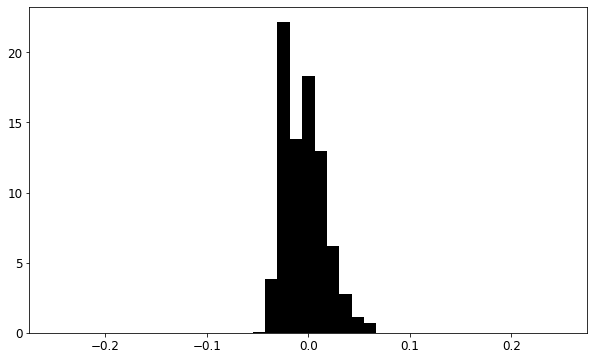

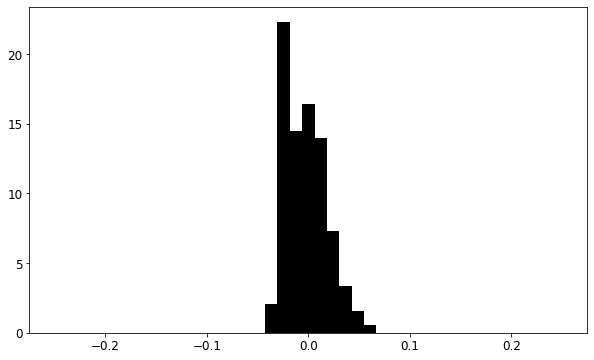

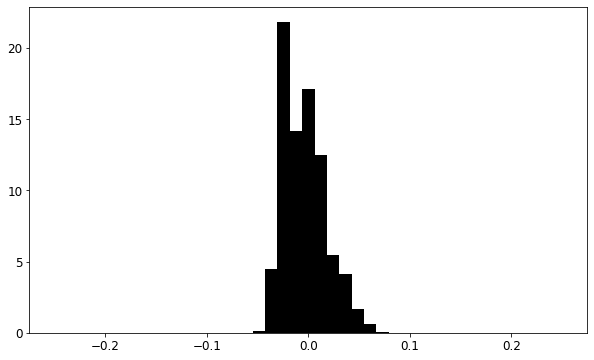

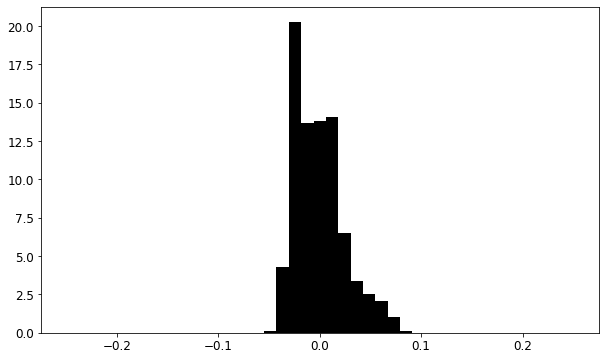

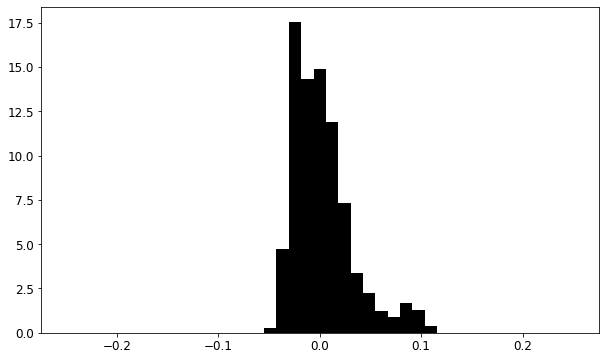

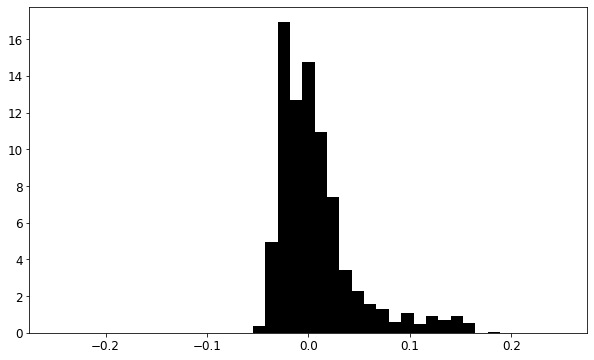

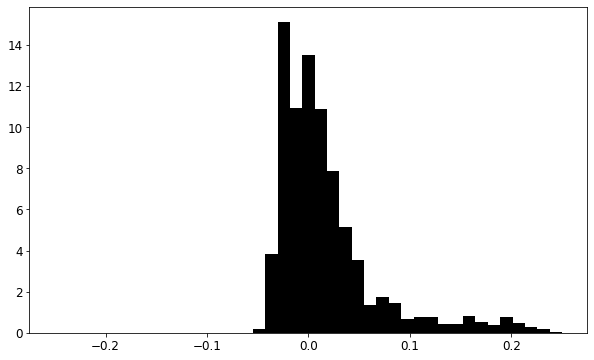

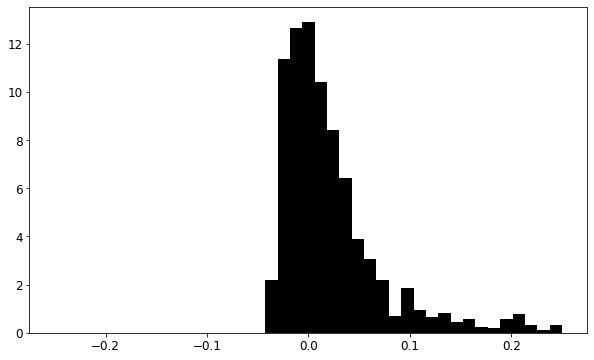

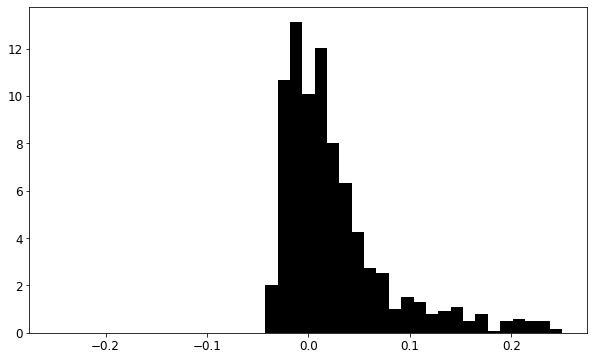

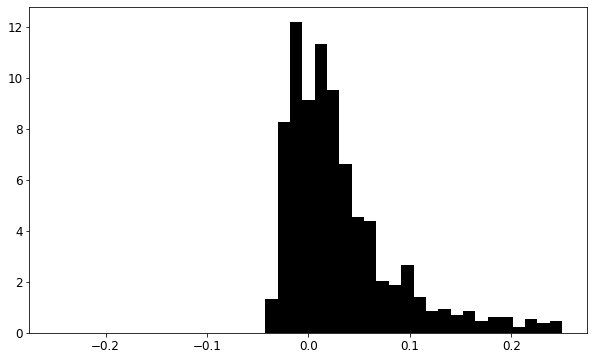

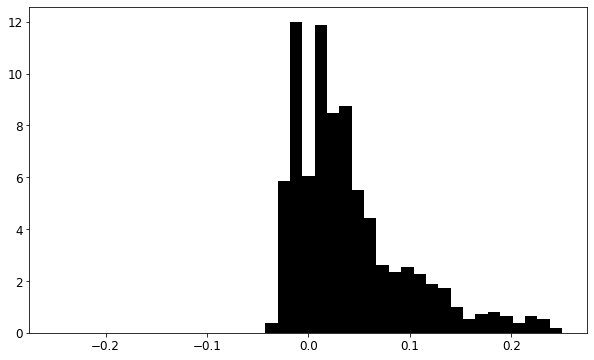

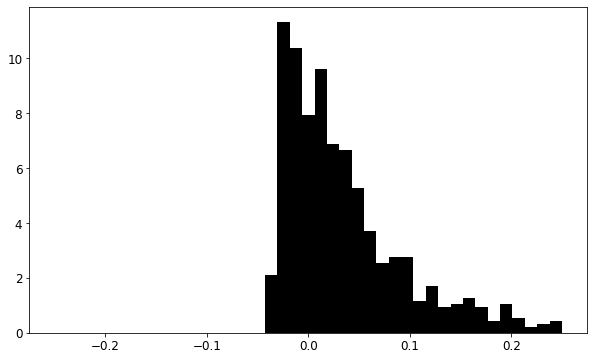

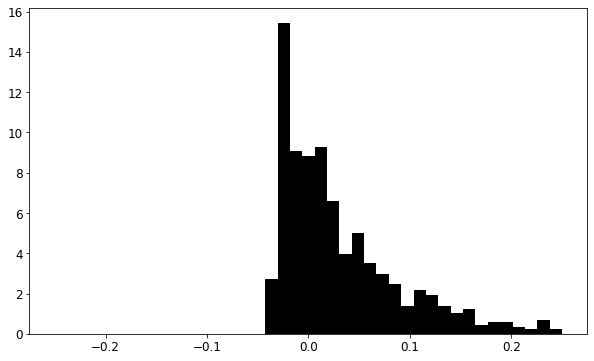

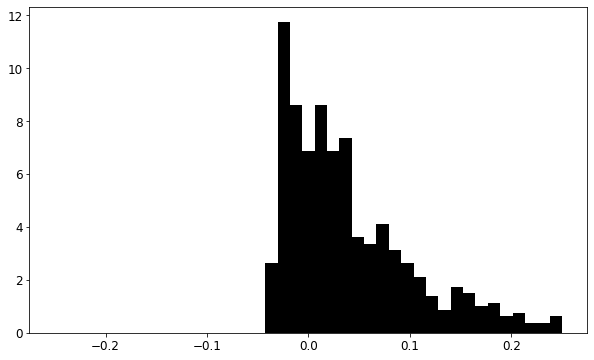

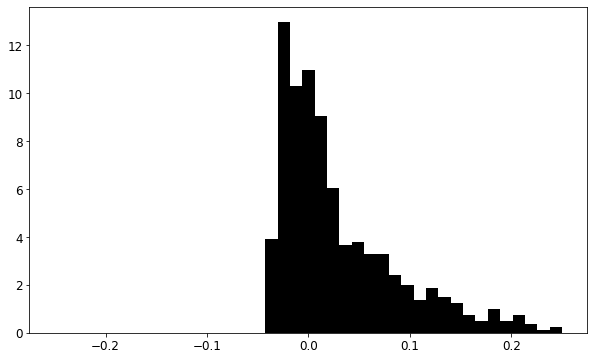

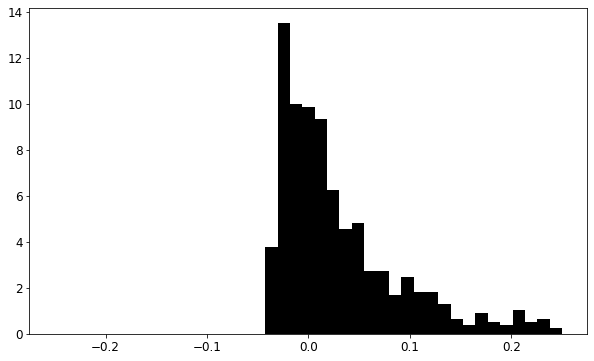

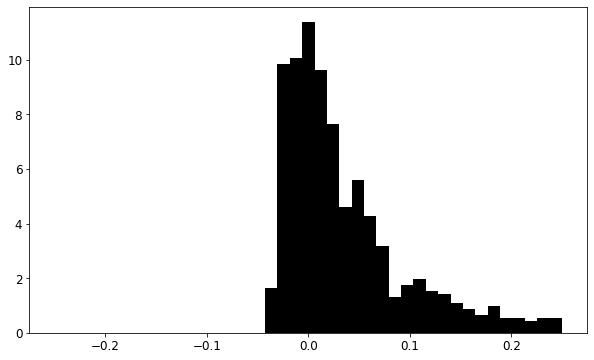

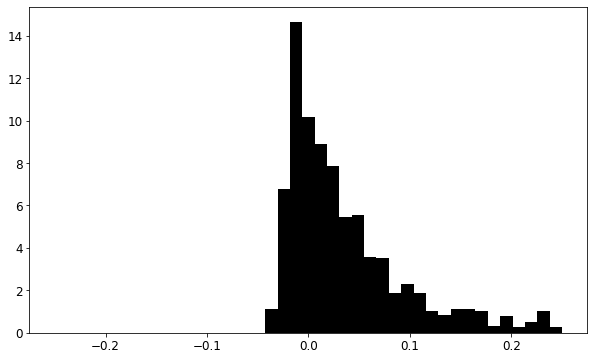

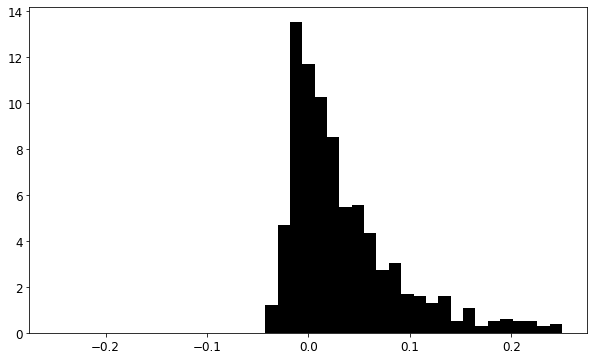

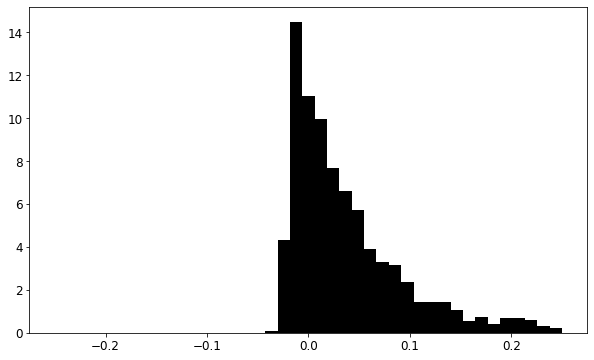

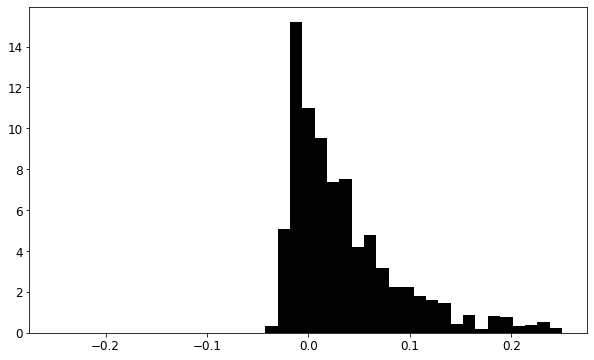

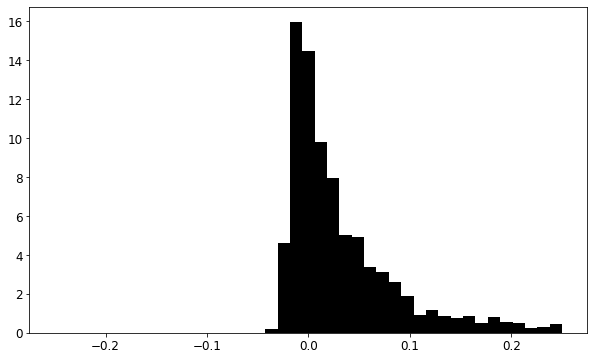

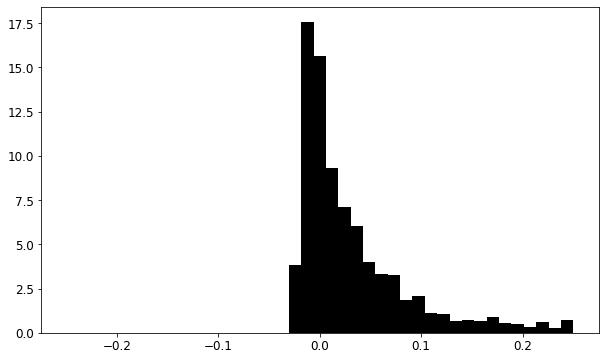

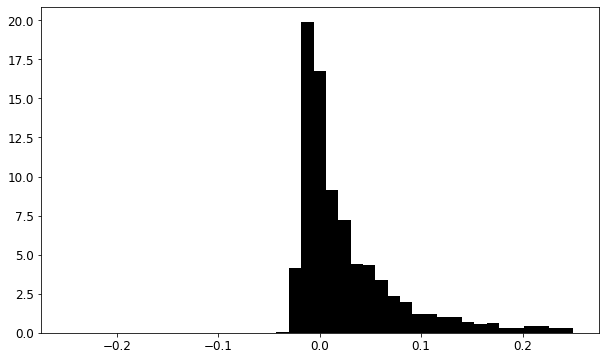

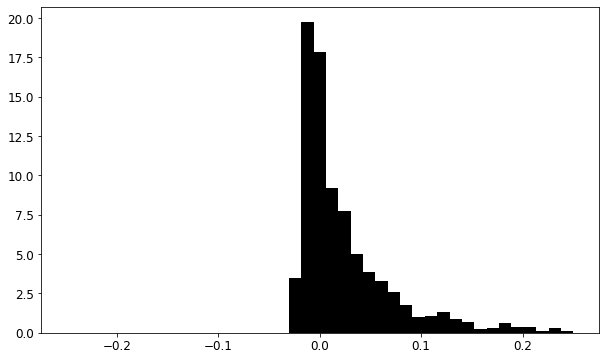

In [25]:




bin_num=41
bin_max =.25
bin_min=-.25
bin_size = (bin_max-bin_min)/bin_num; 
N = int((bin_max-bin_min)/bin_size); Nplus1 = N + 1
bin_list = np.linspace(bin_min, bin_max, Nplus1)

total_cells=0
x_devmeans=[]
y_devmeans=[]

freqs_rel=[]
freqs_abs=[]

dist_relfreqs=[]

html_table=[]

frames=range(int(frame_experiment_start),int(frame_experiment_end+1))

for t, frame in enumerate(frames):
    filter_t=filterFrames(data_frame, [frame])
    
    this_GFP=data_GFP[filter_t]
    this_DsRed=data_DsRed[filter_t]
    
    relFG=[g-meanGFP for g in this_GFP]
    relFG=[(g/meanGFP)-1 for g in this_GFP]
    relFR=[r-meanDsRed for r in this_DsRed]
    
    this_xmean= np.mean(this_GFP)/meanGFP
    this_ymean= np.mean(this_DsRed)/meanDsRed
    #this_freq=(this_ymean)-(this_xmean)
    
    this_freq=np.mean(relFG)
    #this_freq=np.mean(relFR)
    
    
    this_cells=this_GFP.size
    total_cells=total_cells+this_cells
    
        
    x_devmeans.append(this_xmean)
    y_devmeans.append(this_ymean)
    
    freqs_rel.append(this_freq)
    freqs_abs.append(this_xmean)
    
    html_row=("%s,%s,%.1f,%.3f,%.1f,%.3f,%.4f,%s"%(times[t],frame,np.mean(this_GFP),this_xmean,np.mean(this_DsRed),this_ymean,this_freq,this_cells)).split(",")
    html_table.append(html_row)
    
    #Compute frequency distribution
    weights = np.ones_like(relFG)/len(relFG)
    n, bins, patches = plt.hist(relFG, bins=bin_list,  facecolor='black', alpha=1, weights=weights,density=True) #
    plt.show()
    plt.close()
    dist_relfreqs.append(n.tolist())
    
        
    
    
dist_relfreqs=np.array([np.array(xi) for xi in dist_relfreqs])




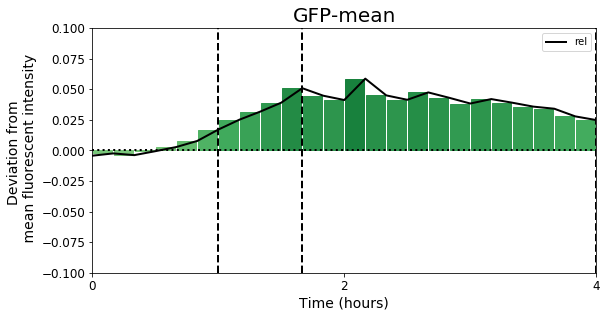

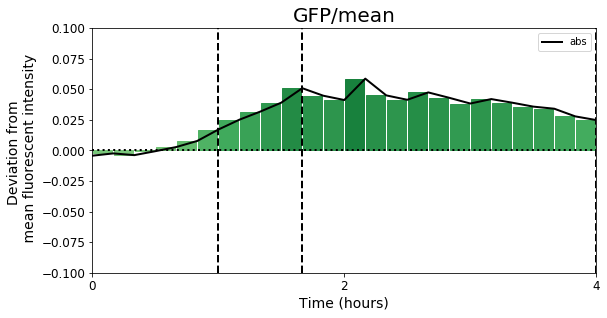


Saved as /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/figures/MGGT-AMP-Pulse_time_v_DevMean_1.tif


In [26]:
interv=1
Ncolors=100
import matplotlib.cm as cm

##########################################################
freqs=freqs_rel.copy()
ymin=-.1
ymax=.1




#Plot figure
fig, ax = plt.subplots(ncols=1, figsize=(10, 4.5))
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})

dx=(frames[1]-frames[0])*frame2min
xdev=[(this_x-frame2min*interv/2) for this_x in times[:]]
ydev=[this_y for this_y in freqs[:]]

cmap = cm.get_cmap("Greens", Ncolors+1) #generate a jet map with 10 values 
cmap_vals = cmap(np.arange(Ncolors+1))


dy=(ymax+np.abs(ymin))/Ncolors
ls=np.arange(ymin,ymax+dy,dy)
colors=[]
for thisy in ydev:
    thisColor=cmap_vals[find_nearest(ls,thisy),:]
    colors.append(thisColor)

ax.bar(xdev,ydev,0.9*interv*frame2min, color = colors, edgecolor =  colors)
ax.plot(times,ydev,color='black', linewidth=2,label="rel")
#ax.plot(times,ydev_phi,color='blue', linewidth=1,label="phi")
#ax.plot(times,ydev_phi_N,color='green', linewidth=1,label="phiN")

ax.plot([0,t_experiment_end],[0,0], 'k:')

ix=range(t_experiment_start*frame2min,t_experiment_end*frame2min,120)
lx= [int(index/60) for index in ix]
ax.set_xticks(ix)
ax.set_xticklabels(lx)

#Annotates signal
ax.axvline(t_signal_start, color='k', linestyle='--')
ax.axvline(t_signal_end, color='k', linestyle='--')
ax.axvline(t_experiment_end, color='k', linestyle='--')
ax.axis([t_experiment_start,t_experiment_end,ymin,ymax])

#ax.set_axis_bgcolor('white')
ax.set_xlabel('Time (hours)',fontsize=14)
ax.set_ylabel('Deviation from \n mean fluorescent intensity',fontsize=14)
ax.set_title(label="GFP-mean")
ax.legend(fontsize='small')
#figName='%s%s_time_v_intensity_rel.tif'%(figurePath, expeLabel)
#plt.savefig(figName)    
plt.show()
#print("\nSaved as %s"%figName)

##########################################################



##########################################################
freqs=freqs_abs.copy()
ymin=-.1
ymax=.1




#Plot figure
fig, ax = plt.subplots(ncols=1, figsize=(10, 4.5))
fig.subplots_adjust(left=0.2) # or whatever

plt.rcParams.update({'font.size': 12})

dx=(frames[1]-frames[0])*frame2min
xdev=[(this_x-frame2min*interv/2) for this_x in times[:]]
ydev=[this_y-1 for this_y in freqs[:]]

cmap = cm.get_cmap("Greens", Ncolors+1) #generate a jet map with 10 values 
cmap_vals = cmap(np.arange(Ncolors+1))


dy=(ymax+np.abs(ymin))/Ncolors
ls=np.arange(ymin,ymax+dy,dy)
colors=[]
for thisy in ydev:
    thisColor=cmap_vals[find_nearest(ls,thisy),:]
    colors.append(thisColor)

ax.bar(xdev,ydev,0.9*interv*frame2min, color = colors, edgecolor =  colors)
ax.plot(times,ydev,color='black', linewidth=2,label="abs")
#ax.plot(times,ydev_phi,color='blue', linewidth=1,label="phi")
#ax.plot(times,ydev_phi_N,color='green', linewidth=1,label="phiN")

ax.plot([0,t_experiment_end],[0,0], 'k:')

ix=range(t_experiment_start*frame2min,t_experiment_end*frame2min,120)
lx= [int(index/60) for index in ix]
ax.set_xticks(ix)
ax.set_xticklabels(lx)

#Annotates signal
ax.axvline(t_signal_start, color='k', linestyle='--')
ax.axvline(t_signal_end, color='k', linestyle='--')
ax.axvline(t_experiment_end, color='k', linestyle='--')
ax.axis([t_experiment_start,t_experiment_end,ymin,ymax])

#ax.set_axis_bgcolor('white')
ax.set_xlabel('Time (hours)',fontsize=14)
ax.set_ylabel('Deviation from \n mean fluorescent intensity',fontsize=14)
ax.set_title(label="GFP/mean")
ax.legend(fontsize='small')
figName='%s%s_time_v_DevMean_1.tif'%(figurePath, expeLabel)
plt.savefig(figName)    
plt.show()
print("\nSaved as %s"%figName)



### Replicates




In [27]:
#Define time interval for baseline observation
nodrug_t=range(t_experiment_start,t_signal_start)
nodrug_frame=range(frame_experiment_start,frame_signal_start)
filter_t=filterFrames(data_frame, nodrug_frame)
frames=range(int(frame_experiment_start),int(frame_experiment_end+1))

print("No-drug interval (frames): %s"%nodrug_frame)
print("No-drug interval (mins): %s"%nodrug_t)

#Compute fluorescence intensity statistics (population-level)
meanGFP= np.mean(data_GFP[filter_t])
meanDsRed= np.mean(data_DsRed[filter_t])
print("### Population-level:")
print("meanGFP=%s\tmeanDsRed=%s"%(meanGFP, meanDsRed))

minGFP= np.min(data_GFP)
minDsRed= np.min(data_DsRed)
print("minGFP:%s\t\tminDsRed:%s"%(minGFP, minDsRed))

maxGFP= np.max(data_GFP)
maxDsRed= np.max(data_DsRed)
print("maxGFP:%s\t\tmaxDsRed:%s"%(maxGFP, maxDsRed))


No-drug interval (frames): range(10, 16)
No-drug interval (mins): range(0, 60)
### Population-level:
meanGFP=122.08274150626534	meanDsRed=107.7401264694484
minGFP:116.333		minDsRed:105.96
maxGFP:187.899		maxDsRed:203.094


In [28]:
#Compute fluorescence intensity statistics (per trap)
meanGFP_pos=[]   
meanDsRed_pos=[] 
html_table=[]
#print("Positions: %s"%list_pos)
for this_pos in list_pos:
    
    filter_pos=filterPos(data_pos, this_pos)
    
    
    filter_intersect = list(set(filter_pos).intersection(set(filter_t)))
    data_GFP_pos=data_GFP[filter_intersect]
    data_DsRed_pos=data_DsRed[filter_intersect]
    
    meanGFP_pos.append(np.mean(data_GFP_pos))
    meanDsRed_pos.append(np.mean(data_DsRed_pos))
    html_table.append([this_pos, len(filter_intersect), np.mean(data_GFP_pos),  np.mean(data_DsRed_pos)])
    #print("meanGFP_pos%s=%s\tmeanDsRed_pos%s=%s"%(np.mean(data_GFP_pos), this_pos, np.mean(data_DsRed_pos), this_pos))
    
display(HTML(
    '<table><tr><td>pos</td><td>Number of Cells</td><td>Mean(GFP)</td><td>Mean(DsRed)</td></tr><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
        '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in html_table)
    )
))    

HTML(value='<table><tr><td>pos</td><td>Number of Cells</td><td>Mean(GFP)</td><td>Mean(DsRed)</td></tr><tr><td>…

In [29]:
total_cells=0
cells_pos=[]
freqs_pos=[]
x_devmeans_pos=[]
y_devmeans_pos=[]
html_table=[]
relF=[]
for p, this_pos in enumerate(list_pos):
    
    filter_pos=filterPos(data_pos, this_pos)
    
    x_devmeans_frames=[]
    y_devmeans_frames=[]
    freqs_frames=[]
    
    cells_frames=[]
    
    for t, frame in enumerate(frames):
        print(this_pos,int(frame*100/frames[-1]),end='%\r')
        filter_frame=filterFrames(data_frame, [frame])
        filter_intersect = list(set(filter_pos).intersection(set(filter_frame)))
        
        this_GFP=data_GFP[filter_intersect]
        this_DsRed=data_DsRed[filter_intersect]
        
       
        
        this_xmean= (np.mean(this_GFP)/meanGFP_pos[p])-1
        this_ymean= np.mean(this_DsRed)/meanDsRed_pos[p]
        
        this_freq=this_xmean
        
        
        this_cells=this_GFP.size
        total_cells=total_cells+this_cells

        cells_frames.append(this_cells)
        x_devmeans_frames.append(this_xmean)
        y_devmeans_frames.append(this_ymean)
        #print(this_freq)
        freqs_frames.append(this_freq)
        
        
    freqs_pos.append(freqs_frames)
    
    cells_pos.append(cells_frames)
    x_devmeans_pos.append(x_devmeans_frames)
    y_devmeans_pos.append(y_devmeans_frames)
    print()

xy01 100%
xy04 100%
xy05 100%
xy06 100%
xy07 100%
xy09 100%
xy12 100%
xy13 100%


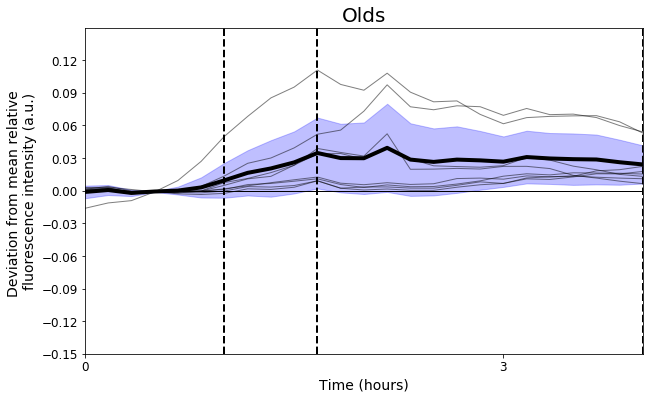

In [30]:
this_maxY=.15

xh=np.arange(0,len(freqs_pos[p]))*frame2min/60
meanfreq_pos=np.mean(freqs_pos,axis=0)
stdfreq_pos=np.std(freqs_pos,axis=0)

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(10,6))

#Annotates signal
ax.axvline(t_signal_start/60, color='k', linestyle='--')
ax.axvline(t_signal_end/60, color='k', linestyle='--')
ax.axvline(t_experiment_end/60, color='k', linestyle='--')
ax.axhline(0, color='k', linestyle='-',linewidth=1)  

#Plot mean
#pstd0=ax.plot(xh, meanfreq_pos+stdfreq_pos,'k-',linewidth=2)
#pstd1=ax.plot(xh, meanfreq_pos-stdfreq_pos,'k-',linewidth=2)
ax.fill_between(xh, meanfreq_pos-stdfreq_pos, meanfreq_pos+stdfreq_pos, color='blue', alpha=0.25)
pmean=ax.plot(xh, meanfreq_pos,'k-',linewidth=4, label="Population-level mean")
    
    
reps=[]
for p, this_pos in enumerate(list_pos):
    ax.plot(xh, np.array(freqs_pos[p]),'-k',alpha=0.5,linewidth=1, label="pos_%s"%list_pos[p])
    
ax.set_xlabel('Time (hours)', fontsize=14)
ax.set_ylabel('Deviation from mean relative \nfluorescence intensity (a.u.)', fontsize=14)
#ax.axis('tight')
ax.set_xlim( (t_experiment_start/60,t_experiment_end/60) )
ax.set_ylim( (-this_maxY, this_maxY) )
ax.xaxis.set_ticks(np.arange(t_experiment_start/60,(t_experiment_end+1)/60,3))
#ax.yaxis.set_ticks(np.arange(-this_maxY,this_maxY+.25,.25))
ax.yaxis.set_ticks(np.arange(-this_maxY,this_maxY,this_maxY/5))
ax.set_title(label="Olds")
figName='%s%s_DevMeanReps.tif'%(figurePath, expeLabel)
#ax.legend(fontsize='small')
#plt.savefig(figName)
plt.show()
plt.close()
#print("Saved as %s"%figName)



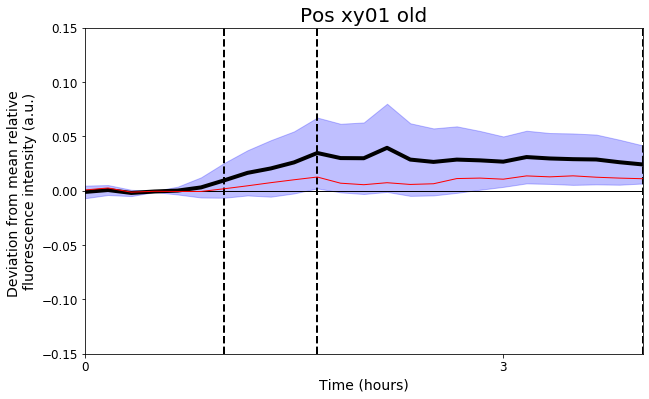

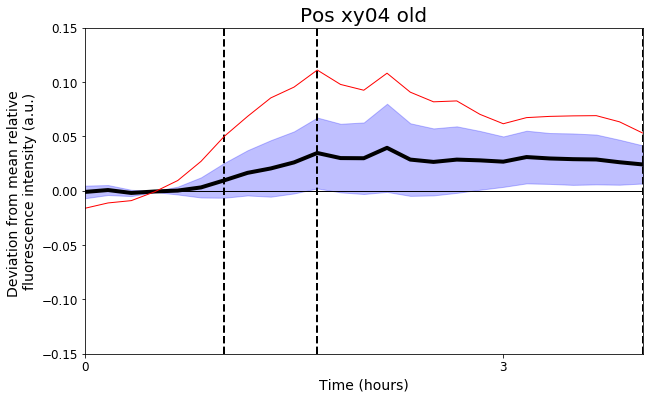

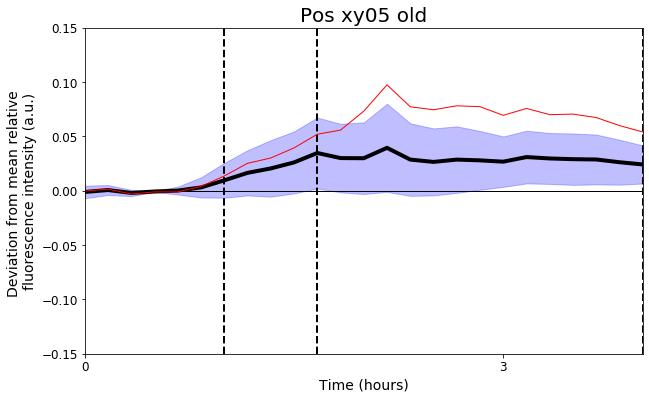

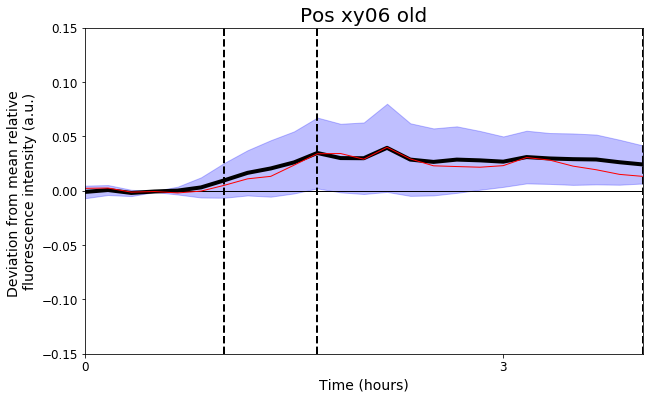

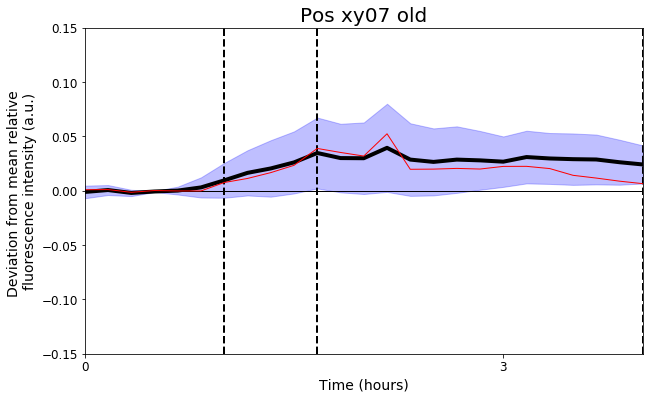

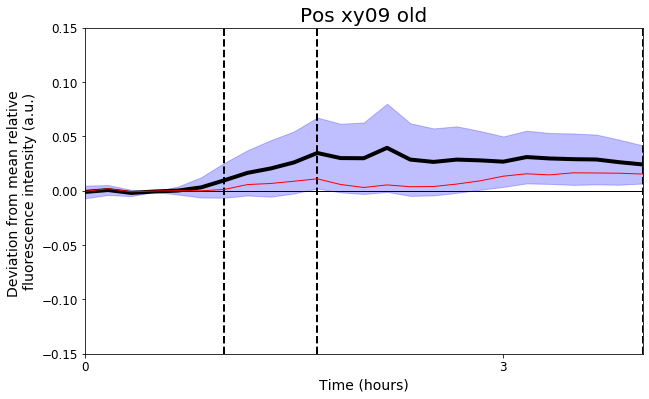

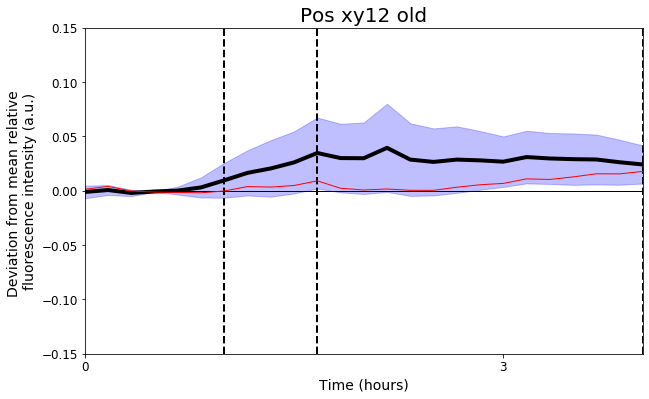

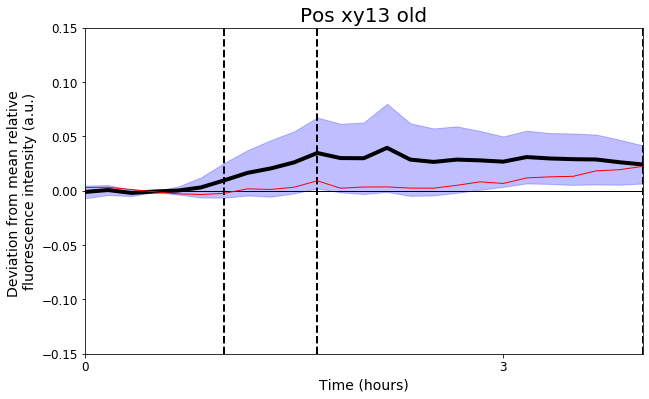

In [31]:

xh=np.arange(0,len(freqs_pos[p]))*frame2min/60
meanfreq_pos=np.mean(freqs_pos,axis=0)
stdfreq_pos=np.std(freqs_pos,axis=0)

plt.rcParams.update({'font.size': 12})

    
# reps=[]
for p, this_pos in enumerate(list_pos):
    fig, ax_i = plt.subplots(figsize=(10,6))

#Annotates signal
    ax_i.axvline(t_signal_start/60, color='k', linestyle='--')
    ax_i.axvline(t_signal_end/60, color='k', linestyle='--')
    ax_i.axvline(t_experiment_end/60, color='k', linestyle='--')
    ax_i.axhline(0, color='k', linestyle='-',linewidth=1)  

#Plot mean
#pstd0=ax.plot(xh, meanfreq_pos+stdfreq_pos,'k-',linewidth=2)
#pstd1=ax.plot(xh, meanfreq_pos-stdfreq_pos,'k-',linewidth=2)
    ax_i.fill_between(xh, meanfreq_pos-stdfreq_pos, meanfreq_pos+stdfreq_pos, color='blue', alpha=0.25)
    pmean=ax_i.plot(xh, meanfreq_pos,'k-',linewidth=4, label="Population-level mean")

    
    ax_i.plot(xh, np.array(freqs_pos[p]),'-r',alpha=1,linewidth=1, label="pos_%s"%list_pos[p])
    
    ax_i.set_xlabel('Time (hours)', fontsize=14)
    ax_i.set_ylabel('Deviation from mean relative \nfluorescence intensity (a.u.)', fontsize=14)
#ax.axis('tight')
    ax_i.set_xlim( (t_experiment_start/60,t_experiment_end/60) )
    ax_i.set_ylim( (-this_maxY, this_maxY) )
    ax_i.xaxis.set_ticks(np.arange(t_experiment_start/60,(t_experiment_end+1)/60,3))
    #ax_i.yaxis.set_ticks(np.arange(-this_maxY,this_maxY+.25,.25))
    ax.yaxis.set_ticks(np.arange(-this_maxY,this_maxY,this_maxY/5))
    ax_i.set_title('Pos %s old'%(this_pos))

    #figName='%s%s_DevMeanReps_%s.tif'%(figurePathDM, expeLabel,this_pos)
    #plt.savefig(figName)
    plt.show()
    
    #print("Saved as %s"%figName)
    #print(nana)


In [32]:
list_to_plot_frames

[10, 15, 19, 34]

## Plot 2D histogram of fluorescent intensities

In [33]:
maxDsRed

203.094

/home/charly/.anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


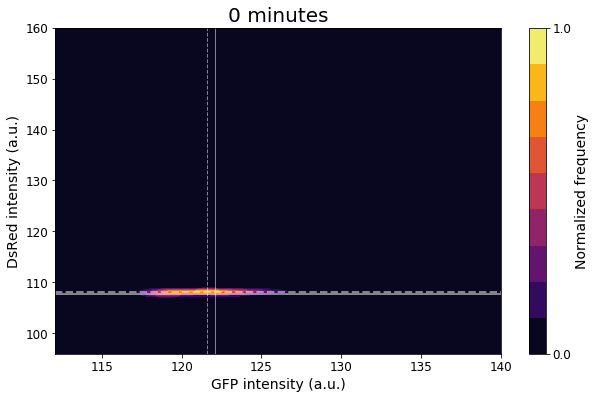

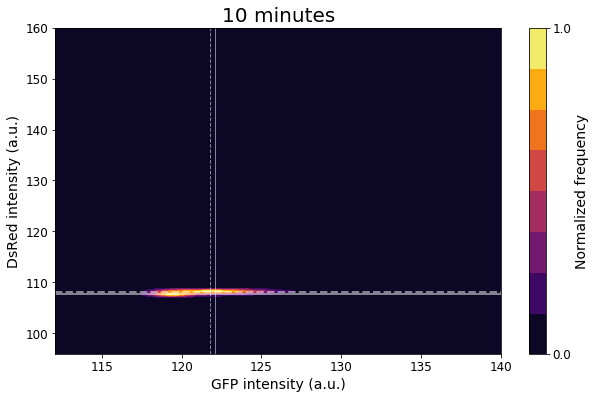

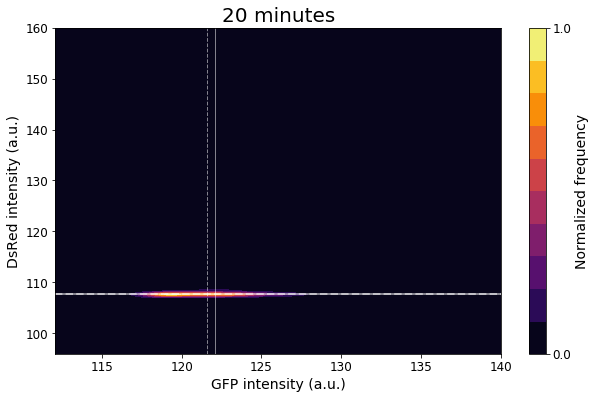

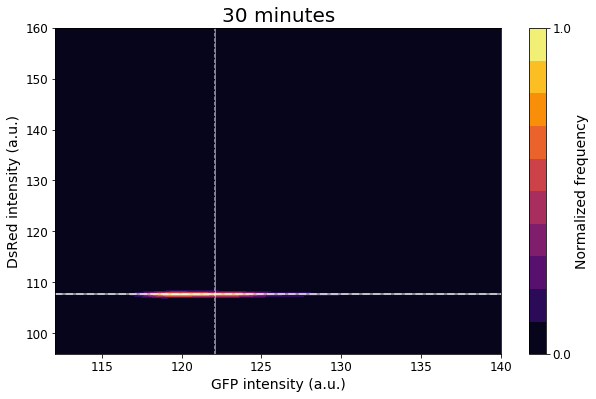

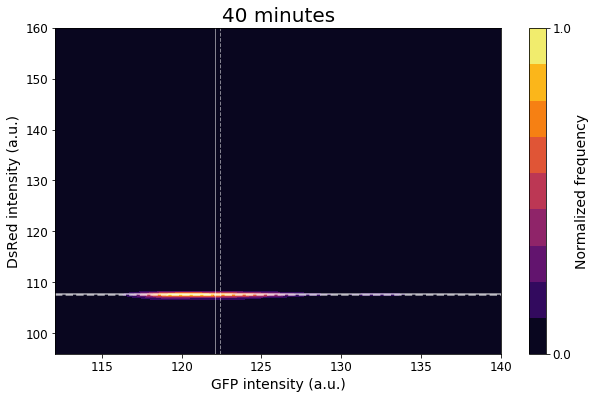

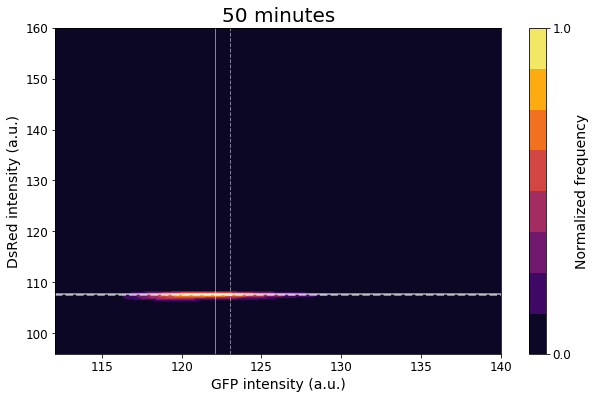

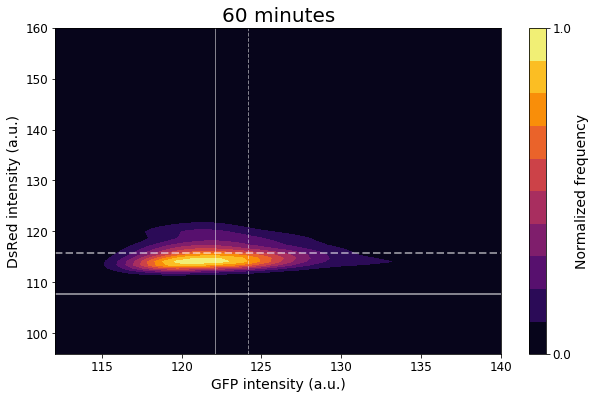

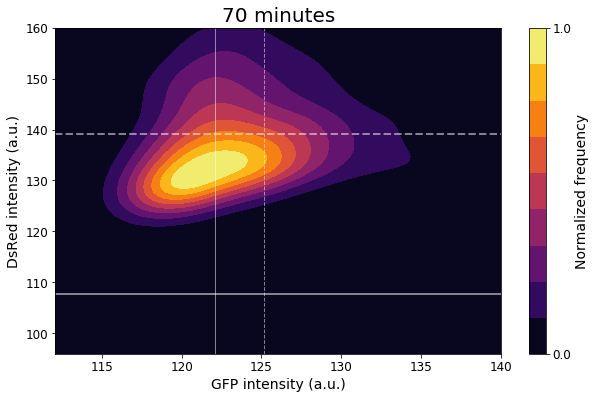

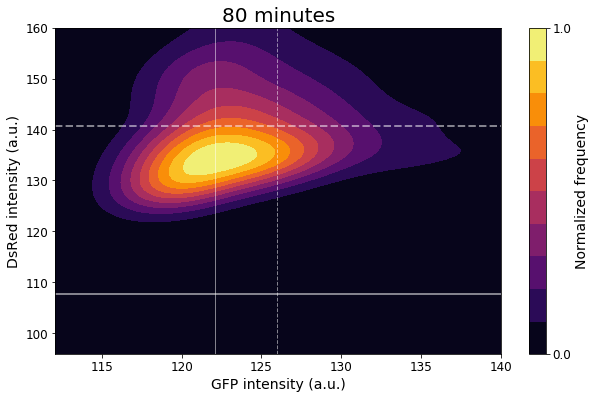

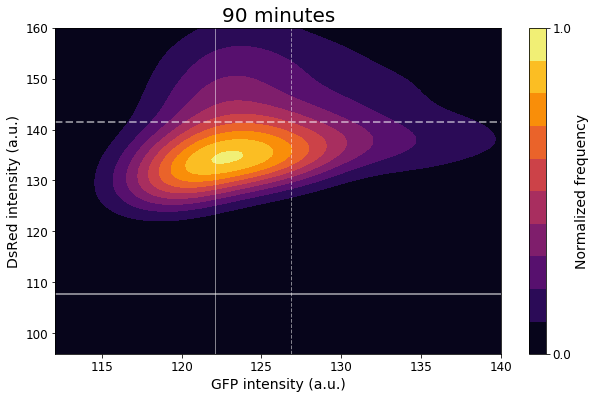

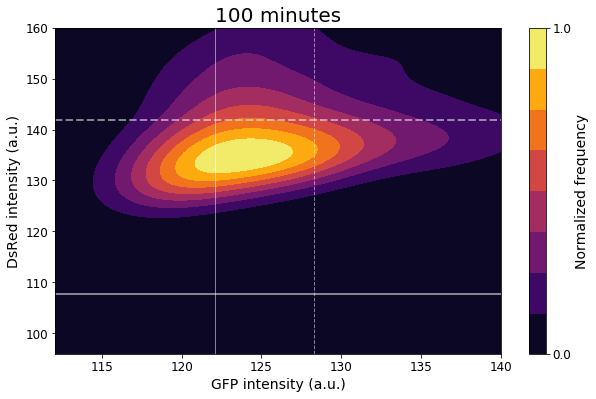

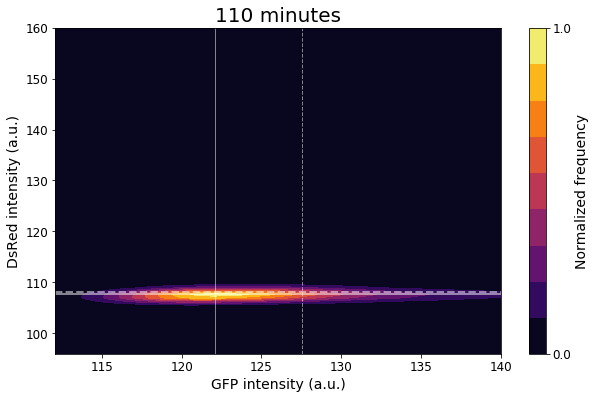

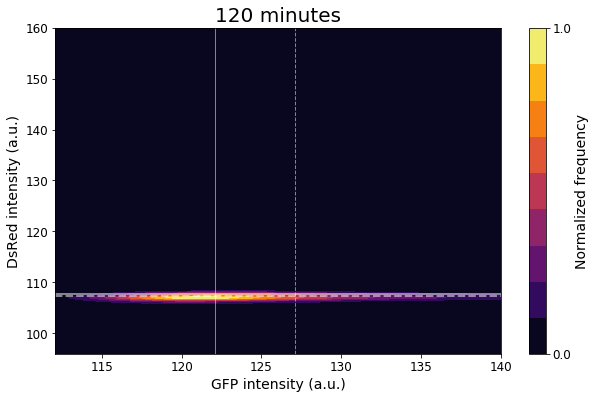

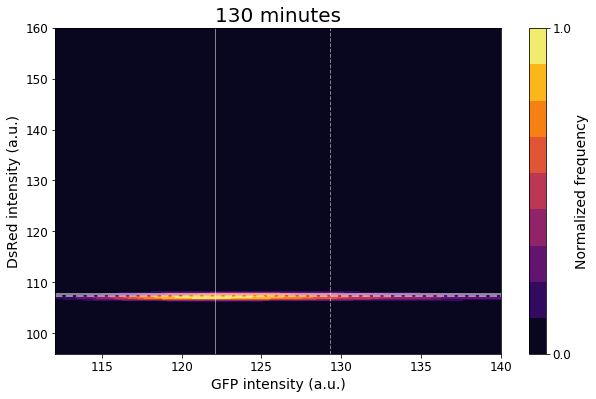

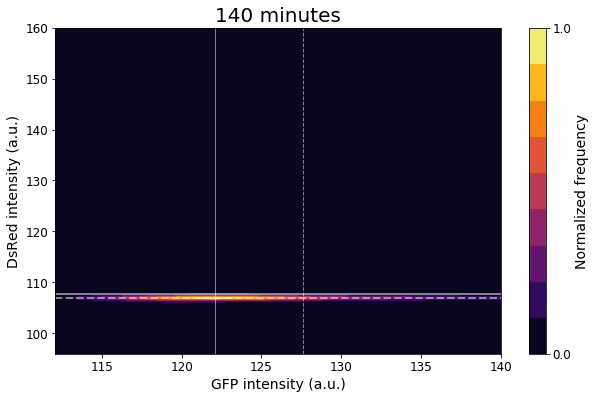

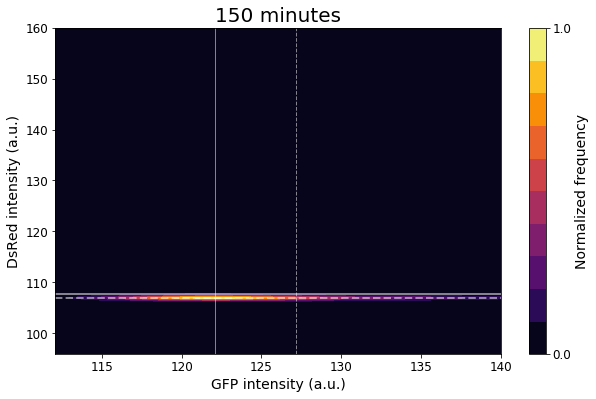

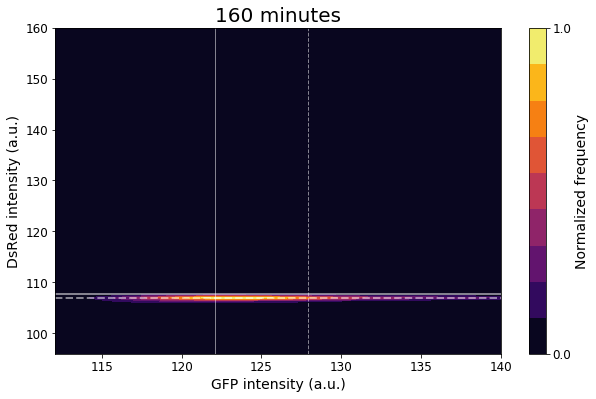

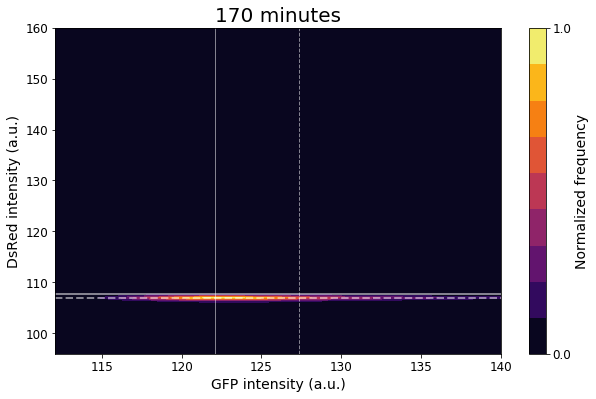

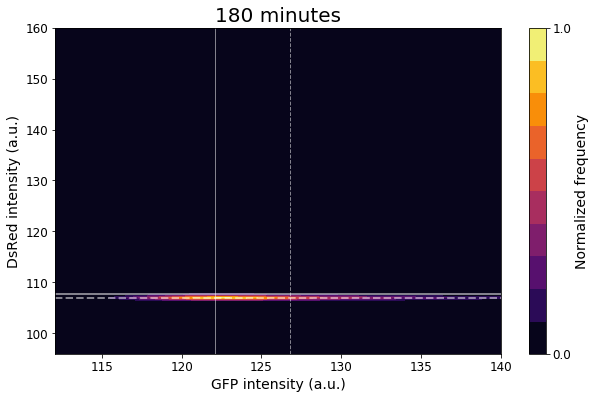

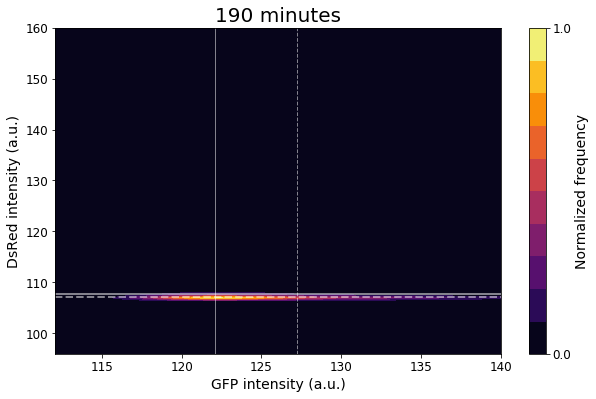

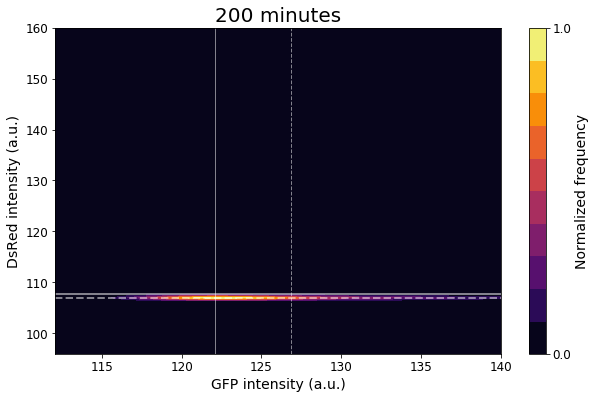

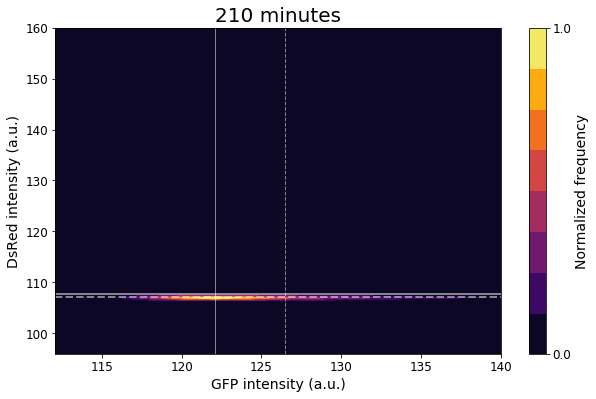

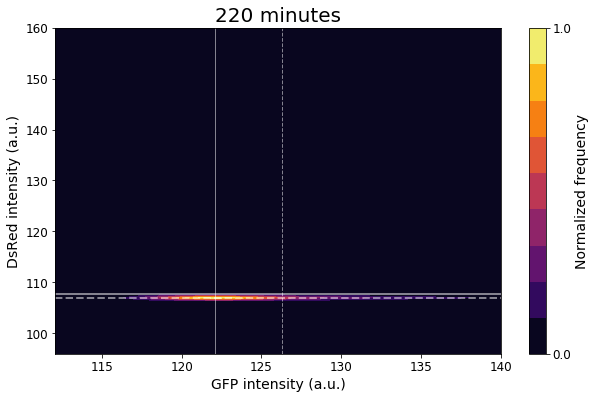

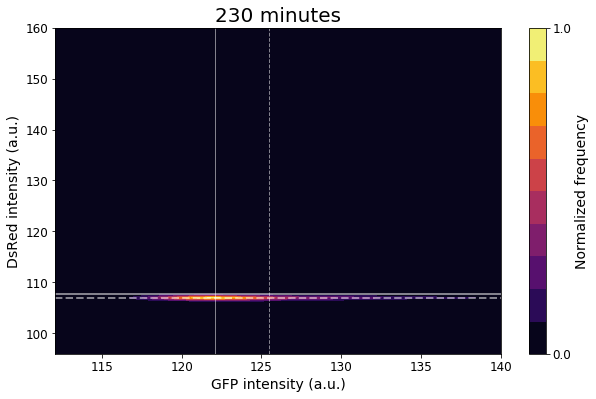

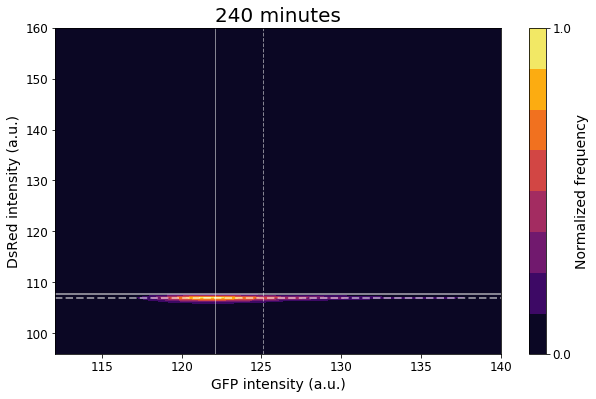

Saved as /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/figures/2Dhist/MGGT-AMP-Pulse_2Dhist_<pos>_<t>.tif


In [34]:

outDir="%s2Dhist/"%figurePath
if not os.path.exists(outDir):
    os.mkdir(outDir)
frames=range(int(frame_experiment_start),int(frame_experiment_end+1))
#for t in list_to_plot_frames:
for t in frames:
#     if t is not frames[0] and t is not frames[-1]:
#         continue
    
    filter_t=filterFrames(data_frame, [t])
    
    this_GFP=data_GFP[filter_t]
    this_DsRed=data_DsRed[filter_t]

    x=[this_x for this_x in this_GFP]
    y=[this_y for this_y in this_DsRed]

    xmin = meanGFP-10
    ymin = meanDsRed-10
    ymin = minDsRed-10
    xmax = maxGFP
    xmax = 140
    ymax = 160
    #ymax = maxDsRed
    
    fig, ax = plt.subplots()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    xedges, yedges = np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100)
    hist, xedges, yedges = np.histogram2d(x, y, (xedges, yedges))
    
    
    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    # Contourf plot
    num_levels=10
    hb = ax.contourf(xx, yy, f, num_levels-1, cmap='inferno')
    ax.axhline(meanDsRed, color='w', linestyle='-',alpha=0.5)
    ax.axvline(meanGFP, color='w', linestyle='-',linewidth=1,alpha=0.5) 
    ax.axhline(np.mean(y), color='w', linestyle='--',alpha=0.5)
    ax.axvline(np.mean(x), color='w', linestyle='--',linewidth=1,alpha=0.5)  
    
    
    #xidx = np.clip(np.digitize(x, xedges), 0, hist.shape[0]-1)
    #yidx = np.clip(np.digitize(y, yedges), 0, hist.shape[1]-1)
    #c = hist[xidx, yidx]
    #h=plt.scatter(x, y, c='w', lw = 0, alpha=0.2)

    #ax.set_axis_bgcolor('black')
    ax.axis([xmin, xmax, ymin, ymax])
    ax.set_xlabel('GFP intensity (a.u.)',fontsize=14)
    ax.set_ylabel('DsRed intensity (a.u.)',fontsize=14)
    ax.set_title('%s minutes'%((t-frame_experiment_start)*frame2min))
                 
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('Number of cells',fontsize=14)
    cb.set_ticks(np.linspace(hb.get_array().min(), hb.get_array().max(), 2))
    cb.set_ticklabels(np.linspace(0, 1., 2))
    cb.set_label('Normalized frequency',fontsize=14)
    
    figName='%s%s_2Dhist_t%s.tif'%(outDir, expeLabel,t)
    plt.savefig(figName)
    
#     if t is not frames[0] and t is not frames[-1]:
#         plt.close()


plt.show()
print("Saved as %s%s_2Dhist_<pos>_<t>.tif"%(outDir, expeLabel))

## Plot relative fluorescence distribution

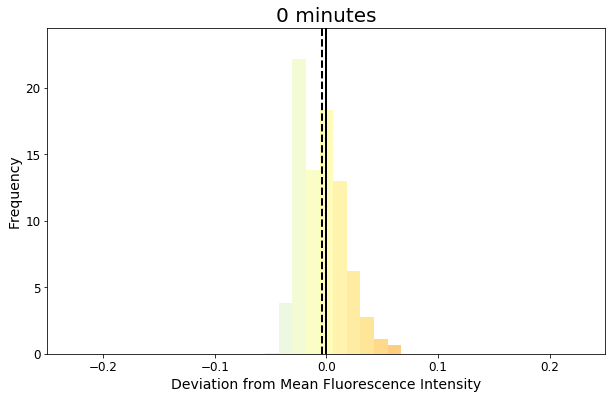

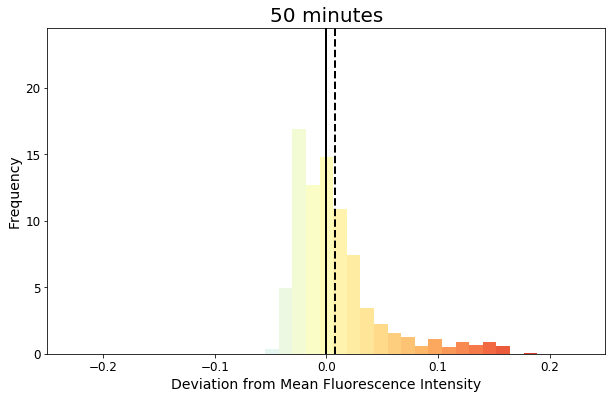

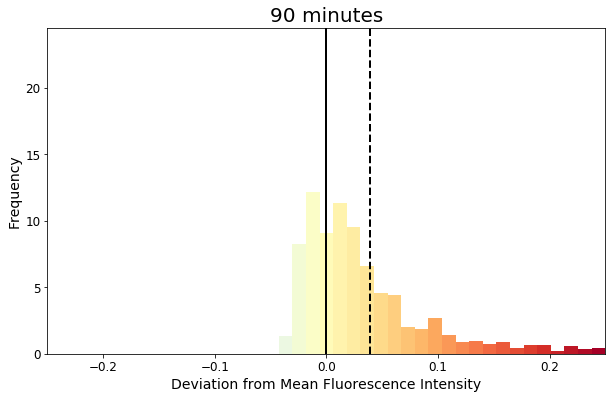

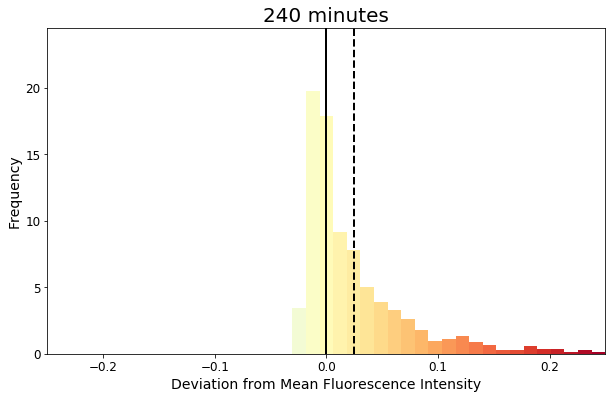

Saved as /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/figures/1Dhist/MGGT-AMP-Pulse_1Dhist_<t>.tif


In [35]:

import matplotlib.patches as patches
frames=range(int(frame_experiment_start),int(frame_experiment_end+1))
outDir="%s1Dhist/"%figurePath
if not os.path.exists(outDir):
    os.mkdir(outDir)

cm = plt.cm.get_cmap('RdYlBu_r')

x_min =-.25 #meanGFP
#y_min =0 #meanDsRed
x_max =.25 
#y_max =3 #meanDsRed
y_min=0
y_max=1.1*np.nanmax(dist_relfreqs)

#for t in frames:
#for t in list_to_plot_frames:
for t in frames:    
    fig, ax = plt.subplots()
    bins=dist_relfreqs[t-frames[0]]
    n=bin_list[1:]-bin_size/2
    
    for ib, b in enumerate(n):
        #ax.bar([b-bin_size/2,b+bin_size/2], [0, bins[ib]], alpha=0.2)
        ax.add_patch(
            patches.Rectangle(
                (b-bin_size/2, 0),   # (x,y)
                bin_size,          # width
                bins[ib],          # height
                facecolor=cm((ib+1)/len(n))
            )
        )
        
    ax.axvline(0, color='k', linestyle='-')
    ax.axvline(ydev[t-frame_experiment_start], color='k', linestyle='--')
   # ax.set_axis_bgcolor('white')
   # ax.set_xlim([bin_min,bin_max])
    ax.set_xlim([x_min,x_max])
    ax.set_ylim([y_min,y_max])
    ax.set_xlabel('Deviation from Mean Fluorescence Intensity',fontsize=14)
    ax.set_ylabel('Frequency',fontsize=14)
    ax.set_title('%s minutes'%((t-frame_experiment_start)*frame2min))
    
    figName='%s%s_1Dhist_t%s.tif'%(outDir, expeLabel,t)
    plt.savefig(figName)
    if t not in list_to_plot_frames:
        plt.close()
    

plt.show()
print("Saved as %s%s_1Dhist_<t>.tif"%(outDir, expeLabel))

## Time-dependant distribution (Heatmap)

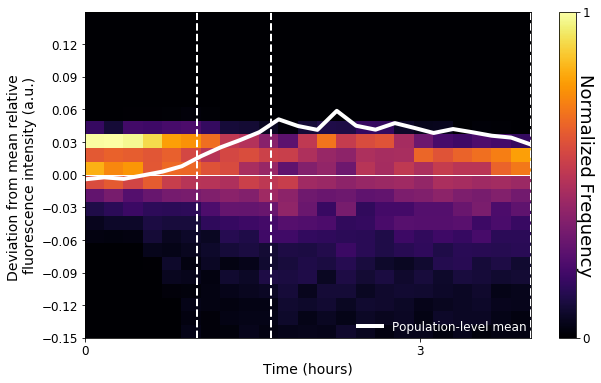

Saved as /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/figures/MGGT-AMP-Pulse_HeatmapDist.tif


In [36]:
#this_maxy=maxy
this_maxY=0.15


c = mcolors.ColorConverter().to_rgb
#rvb = make_colormap([c('black'), c('green')])
rvb= plt.cm.get_cmap('inferno')

plt.rcParams.update({'font.size': 12})
zh = np.rot90(dist_relfreqs)

[numBs, numTs]=zh.shape

xh=np.linspace(0,numTs*frame2min/60,numTs)
yh=np.linspace(bin_min,bin_max,numBs)
maxY=np.max(yh)

fig, ax = plt.subplots(figsize=(10,6))
im =plt.pcolor(xh, yh, zh, cmap=rvb, vmin=np.min(zh), vmax=np.max(dist_relfreqs))

cbar=fig.colorbar(im, ticks=[np.min(zh), np.max(zh)])
cbar.ax.set_yticklabels(['0','1'])
cbar.set_label('Normalized Frequency', rotation=270)

#Annotates signal
ax.axvline(t_signal_start/60, color='w', linestyle='--')
ax.axvline(t_signal_end/60, color='w', linestyle='--')
ax.axvline(t_experiment_end/60, color='w', linestyle='--')
ax.axhline(0, color='w', linestyle='-',linewidth=1)  

#Plot mean
pmean=ax.plot(xh, np.array(ydev),'w-',linewidth=4, label="Population-level mean")
leg=plt.legend(loc=4, borderaxespad=0., fontsize=12)
leg.get_frame().set_alpha(0)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
    
ax.set_xlabel('Time (hours)', fontsize=14)
ax.set_ylabel('Deviation from mean relative \nfluorescence intensity (a.u.)', fontsize=14)
#ax.axis('tight')
ax.set_xlim( (t_experiment_start/60,t_experiment_end/60) )
ax.set_ylim( (-this_maxY, this_maxY) )

ax.xaxis.set_ticks(np.arange(t_experiment_start/60,(t_experiment_end+1)/60,3))
#ax.yaxis.set_ticks(np.arange(-this_maxY,this_maxY+.25,.25))
ax.yaxis.set_ticks(np.arange(-this_maxY,this_maxY,this_maxY/5))


#ax.annotate('AMP', xy=(6, maxY), xytext=(6, maxY*1.25),horizontalalignment='center',arrowprops=dict(facecolor='black', shrink=0.05),)
figName='%s%s_HeatmapDist.tif'%(figurePath, expeLabel)

#plt.savefig(figName)
plt.show()
plt.close()
print("Saved as %s"%figName)


In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')